In [1]:
%matplotlib inline
import numpy as np
from numpy import genfromtxt  
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

## Plotting functions

In [2]:
 def scatter(*data):
    '''
    scatter plot of 1dim data
    
    data list of 1 dim data
    '''
    
    plt.figure(figsize=(9,2))
    
    for x in data:
        plt.scatter(x, np.zeros((len(x), 1)))
        
    plt.yticks(())
    plt.show()
    
def plt_with_gaussians(data, mean, variance):
    '''
    scatter the data,
    and plot the given gaussian distributions
    
    data 1dim data to be scattered
    mean means of the normal distributions
    variance variances of the normal distributions
    '''
    
    plt.figure(figsize=(14, 7))
    
      # generate x values with min and max of the data
    x_values = np.linspace(data.min(), data.max(), 1001)
    # show the gaussians 
    for mu, sig in zip(mean, variance):
        plt.plot(x_values, gaussian(x_values, mu, sig))
        
    # scatter data points on x axis
    plt.scatter(data, np.zeros((len(data), 1)))
    
    plt.yticks(())
    plt.show()

## implementation of

- Gaussian distribution function
- Expectation Maximazation Algorithm
- Akaike Information Criterion

In [3]:
def gaussian(x, mu, sig):
    '''
    returns the likelihood of a point in a one dimensional gaussian
    
    x x value(s)
    mu mean of the gaussian
    sig variance of the gaussian 
    '''
    return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))

In [4]:
def kmeans(data, k, n=10):
    '''
    kmeans clustering algorithm
    
    data 1d array data
    k number of clusters / means
    n times to repeat algorithm
    
    returns means
    '''
    
    # ensure data are 1d ndarray
    data = np.array(data).flatten()
    
    # init means randomly
    mu = np.random.uniform(low=data.min(), high=data.max(), size=k)
     
    # loop through algorithm n times 
    for i in range(n):
        # augment data array k times, then calculate distances to means
        dist = np.abs(data * np.ones(k).reshape(-1, 1) - mu.reshape(-1, 1))
        # generate indices of which point belongs to which cluster
        cluster_indices = dist.swapaxes(0, 1).argmin(axis=1)
        # recalculate means
        for j in range(k): 
            mu[j] = data[cluster_indices == j].mean()
             
    
    return mu 

In [5]:
def em(data, k=1, n=1, init='random', plot=False):
    '''
    1d expectation maximazation algorithm
    
    data 1d numpy array of data
    k number of normal distributions
    n number of em repetitions
    init [default='random', 'kmeans'] how to initialize means and variances
    plot If true, will plot every step
    
    returns mixing coefficients, means, variances
    '''
    
    # ensure data are 1d ndarray
    data = np.array(data).flatten()
    
    # list of means and variances of the k normal distributions to be fitted
    # init randomly between min and max points of data
    min_data, max_data = data.min(), data.max() 
    
    prior = np.full(k, 1 / k)  # assume priors (mixing coefficents) are equal
     
    if init == 'random':
        mean = np.random.uniform(low=min_data, high=max_data, size=k)
        variance = np.random.uniform(low=np.absolute(min_data / 2), high=np.absolute(max_data/2), size=k)
    elif init == 'kmean':
        pass
     
    # repeat algorithm n times
    for i in range(n):
        
        p_x_b = []
        
        # loop through each distribution j
        for j in range(k):
            # calcualate for each point the generative probability that it belongs to the distribution j
            # P(x | b)
            p_x_b.append(gaussian(data, mean[j], variance[j]))
            
        # convert to numpy array
        p_x_b = np.array(p_x_b)
         
        # calculate for each point the probability that it belongs to a distribution,
        # summing up to one ('colorings of the points')
        # P(b|x)
        p_wp = p_x_b * prior.reshape(-1, 1)
        bi =  p_wp / p_wp.sum(axis=0)
         
        # reestimate means
        mean = (bi * data).sum(axis=1) / bi.sum(axis=1)
        
        # reestimate variances
        for j in range(k):
            variance[j] = (bi[j] * (data - mean[j])**2).sum() / bi[j].sum()
            
        # reestimate priors
        unique, counts = np.unique(bi.swapaxes(0, 1).argmax(axis=1), return_counts=True)
        # counts array are in the correct order the counts of points that have the max likelihood
        # if no point belongs to one of the distributions replace this index with a zero in counts
        # compare with np.arange
        unique, counts = unique.tolist(), counts.tolist()
        for m in range(k):
            if m == len(unique) or unique[m] != m:
                unique.insert(m, -1)
                # insert small epsilon so that prior is not zero (division by zero)
                counts.insert(m, 1e-6)
                
                  
        prior = np.array(counts) / data.shape[0]
        
        # plot if shall plot
        if plot:
            plt_with_gaussians(data, mean, variance)
         
        
    # return means and variances
    return prior, mean, variance 

In [6]:
def aic(data, mixing_coefficent, mean, variance):
    '''
    return best model to the Akaike Information Criterion
    
    data 1dim data
    mixing_coefficents mixing coefficients / priors pi
    mean means of the gaussians mu 
    variance variances of the gaussians sigma
    '''
    
    # ensure data are flat ndarray
    data = np.array(data).flatten()
    
    # calculate K (number of parameters)
    K = len(mean) * 3 - 1  # len of prior, mean and variance should be the same
    
    # calculate log-likelihoods
    LL = 0 
        
    for pi, mu, sig in zip(mixing_coefficent, mean, variance):
        LL += pi * gaussian(data, mu, sig)
         
    LL = np.log(LL).sum()
         
    return -2 * LL + 2 * K

### load datasets

In [7]:
def load_iris():
    '''
    Returns a column of all petal lengths.
    '''
    X = genfromtxt("./data/iris.csv", delimiter=',', skip_header=1)
    X = X[:,2]
    X = X.reshape(-1, 1)
    return X

def load_bdp():
    '''
    Returns a column of systolic and diastolic blood pressure values.
    '''
    Z = genfromtxt("./data/bdp.csv", delimiter=',', skip_header=1)
    n = Z.shape[0]
    X = np.zeros(2*n)
    X[:n] = Z[:,2]
    X[n:] = Z[:,3]
    X = X.reshape(-1,1)
    return X

def sample(pi, mu, std, n):
    '''
    Returns a column of n values drawn from a normal mixture model.
    
    Parameter
        pi  k mixing coefficients
        mu  k means
        std k standard deviations
        n   number of data points
        
    Return
        n data points randomly sampled from specified mixture. 
    '''
    y = np.random.choice(len(pi), size=n, p=pi)
    x = np.zeros((n,1))
    for i, comp in enumerate(y):
        x[i] = norm.rvs(mu[comp], std[comp])
    return x


## Examples

[0, 1, 2] 0
[0, 1, 2] 1
[0, 1, 2] 2
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2


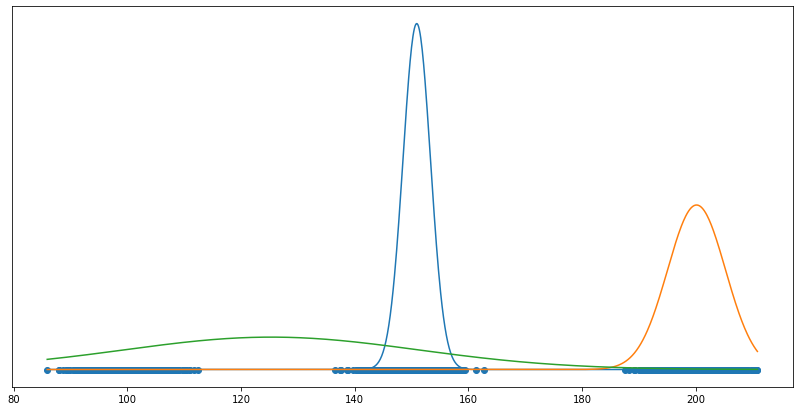

In [8]:
# generate n points from a mixture of fived normal distributions
n = 1000
mu = [100, 150, 200]
std = 5 * np.ones(len(mu))
pi = np.ones(len(mu))/ len(mu)
sample_x = sample(pi, mu, std, n)

priors, mu, sig = em(sample_x, 3, 10)
plt_with_gaussians(sample_x, mu, sig)

[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1


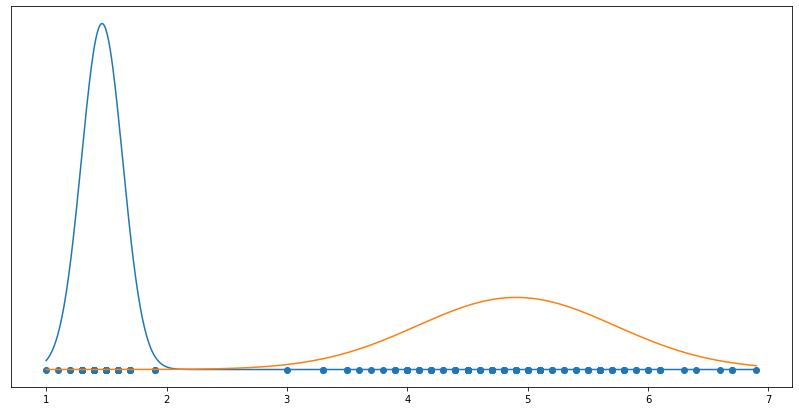

In [9]:
# load petal lengths of iris flowers
iris_x = load_iris()
priors, mu, sig = em(iris_x, 2, 10)
plt_with_gaussians(iris_x, mu, sig)

[0, 1] 0
[0, 1] 1
[1] 0
[-1, 1] 1
[1] 0
[-1, 1] 1
[1] 0
[-1, 1] 1
[1] 0
[-1, 1] 1
[1] 0
[-1, 1] 1
[1] 0
[-1, 1] 1
[1] 0
[-1, 1] 1
[1] 0
[-1, 1] 1
[1] 0
[-1, 1] 1


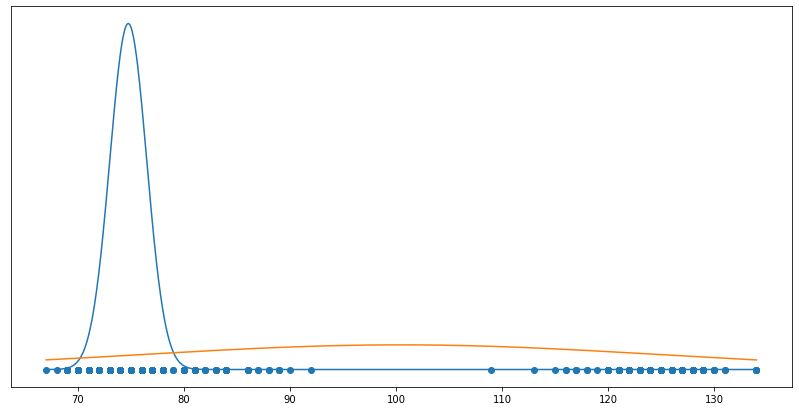

In [10]:
# load blood pressures
bdp_x = load_bdp()
priors, mu, sig = em(bdp_x, 2, 10)
plt_with_gaussians(bdp_x, mu, sig)

### compare my algorithm with sklearn's GMM

In [11]:
for j in range(1, 6):
    # sklearns EM / GMM
    gmm = GaussianMixture(n_components=j, init_params='kmeans', max_iter=100, reg_covar=1e-2)
    gmm.fit(sample_x)
     
    # my gmm 
    my_pi, my_mu, my_sig = em(sample_x, j, 10)
    sk_mu, sk_sig = sk_pi = gmm.means_.flatten(), gmm.covariances_.flatten()
    
    # print difference
    print(f'\n{j}')
    print(f'my mus = {my_mu}')
    print(f'sk mus = {sk_mu}')
    print(f'my sig = {my_sig}')
    print(f'sk sig = {sk_sig}')
    print(f'my aic = {aic(sample_x, my_pi, my_mu, my_sig)}')
    print(f'sk aic = {gmm.aic(sample_x)}')

[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0

1
my mus = [149.69820378]
sk mus = [149.69820378]
my sig = [1689.13320607]
sk sig = [1689.14320607]
my aic = 10273.847846932758
sk aic = 10273.847846950282
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1

2
my mus = [174.36880781 100.30532151]
sk mus = [174.36708827 100.30494538]
my sig = [693.88662368  23.50192063]
sk sig = [693.99253043  23.51245642]
my aic = 9483.743004481745
sk aic = 9483.583300478916
[0, 1, 2] 0
[0, 1, 2] 1
[0, 1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2

3
my mus = [125.33428421 150.92192276 200.14995253]
sk mus = [200.06619144 100.373

# conduct experiment of the assignment

In [12]:
# conduct experiment
def select_gmm(data, log='v'):
    '''
    selects the best model according to aic for k = {1..15}
    
    data 1dim data array
    log [default='v(erbose)', 'vp (verbose-plot)', n(one)]
    '''
    
    # best model and aic
    best = None
    
    for k in range(1, 16):
        # generate gmm
        pi, mu, sig = em(data, k, n=10)  # let em loop n times
        
        # calc aic
        t_aic = aic(data, pi, mu, sig)
        
        # create model dict
        model = {
            'k': k,
            'pi': pi, 
            'mu': mu, 
            'sig': sig, 
            'aic': t_aic
        }
        
        # print model if is verbose
        if log == 'v' or log == 'vp': 
            print(k, t_aic)
        if log == 'vp':
            plt_with_gaussians(data, mu, sig)
        
        # compare current looping model to best model
        if best == None or t_aic > best['aic']:
            best = model
            
            if log == 'v' or log == 'vp':
                print('This is the new best model according to aic!')
        
            
    return best
        
def sel_plt(data):
    '''
    select and plot best model according to aic
    
    data 1dim data array
    '''
    
    model = select_gmm(data, log='vp')
    print('best model:')
    plt_with_gaussians(data, model['mu'], model['sig'])

[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
1 10273.847846932758


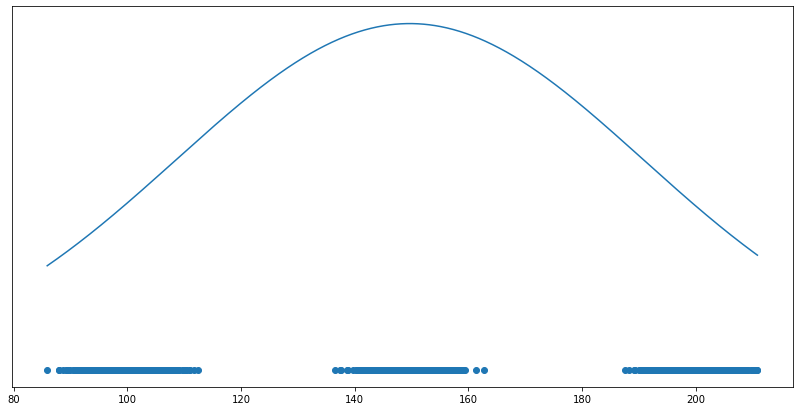

This is the new best model according to aic!
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
2 9510.865568163334


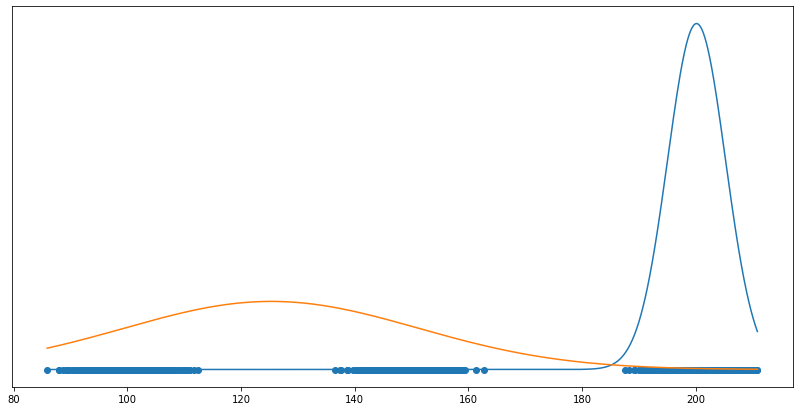

[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1] 0
[0, 1] 1
[0, 1] 2
3 9516.865560501188


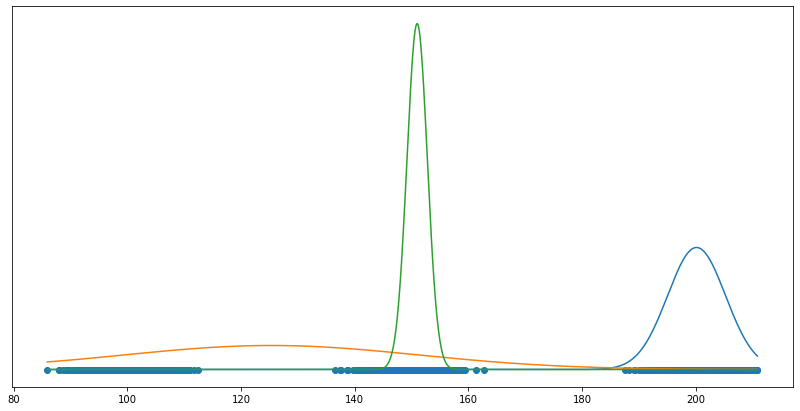

[0, 1, 2, 3] 0
[0, 1, 2, 3] 1
[0, 1, 2, 3] 2
[0, 1, 2, 3] 3
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1, -1] 3
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1, -1] 3
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1, -1] 3
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1, -1] 3
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1, -1] 3
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1, -1] 3
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1, -1] 3
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1, -1] 3
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1, -1] 3
4 9495.742995126882


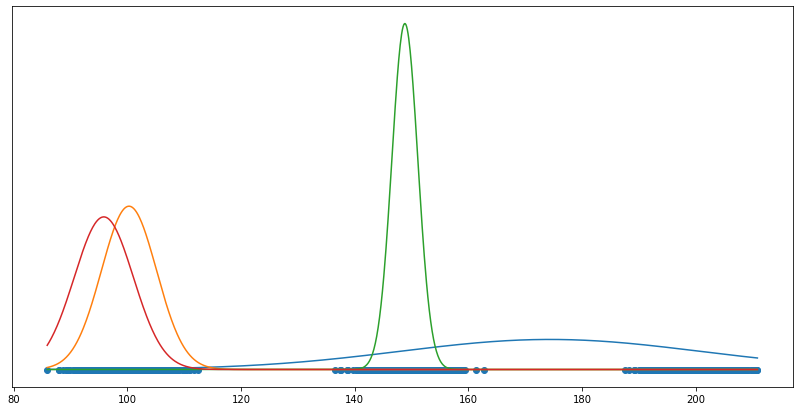

[0, 1, 2, 3, 4] 0
[0, 1, 2, 3, 4] 1
[0, 1, 2, 3, 4] 2
[0, 1, 2, 3, 4] 3
[0, 1, 2, 3, 4] 4
[0, 1, 3, 4] 0
[0, 1, 3, 4] 1
[0, 1, 3, 4] 2
[0, 1, -1, 3, 4] 3
[0, 1, -1, 3, 4] 4
[0, 1, 3, 4] 0
[0, 1, 3, 4] 1
[0, 1, 3, 4] 2
[0, 1, -1, 3, 4] 3
[0, 1, -1, 3, 4] 4
[0, 1, 3, 4] 0
[0, 1, 3, 4] 1
[0, 1, 3, 4] 2
[0, 1, -1, 3, 4] 3
[0, 1, -1, 3, 4] 4
[0, 3, 4] 0
[0, 3, 4] 1
[0, -1, 3, 4] 2
[0, -1, -1, 3, 4] 3
[0, -1, -1, 3, 4] 4
[0, 3, 4] 0
[0, 3, 4] 1
[0, -1, 3, 4] 2
[0, -1, -1, 3, 4] 3
[0, -1, -1, 3, 4] 4
[0, 3, 4] 0
[0, 3, 4] 1
[0, -1, 3, 4] 2
[0, -1, -1, 3, 4] 3
[0, -1, -1, 3, 4] 4
[0, 3, 4] 0
[0, 3, 4] 1
[0, -1, 3, 4] 2
[0, -1, -1, 3, 4] 3
[0, -1, -1, 3, 4] 4
[0, 3, 4] 0
[0, 3, 4] 1
[0, -1, 3, 4] 2
[0, -1, -1, 3, 4] 3
[0, -1, -1, 3, 4] 4
[0, 3, 4] 0
[0, 3, 4] 1
[0, -1, 3, 4] 2
[0, -1, -1, 3, 4] 3
[0, -1, -1, 3, 4] 4
5 8265.435324469825


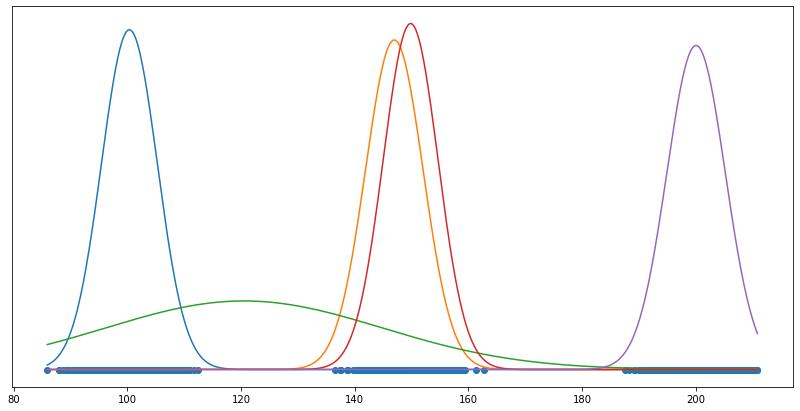

[0, 1, 2, 3, 4] 0
[0, 1, 2, 3, 4] 1
[0, 1, 2, 3, 4] 2
[0, 1, 2, 3, 4] 3
[0, 1, 2, 3, 4] 4
[0, 1, 2, 3, 4] 5
[0, 1, 2, 4] 0
[0, 1, 2, 4] 1
[0, 1, 2, 4] 2
[0, 1, 2, 4] 3
[0, 1, 2, -1, 4] 4
[0, 1, 2, -1, 4] 5
[0, 1, 2, 4] 0
[0, 1, 2, 4] 1
[0, 1, 2, 4] 2
[0, 1, 2, 4] 3
[0, 1, 2, -1, 4] 4
[0, 1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
6 8271.435321427065


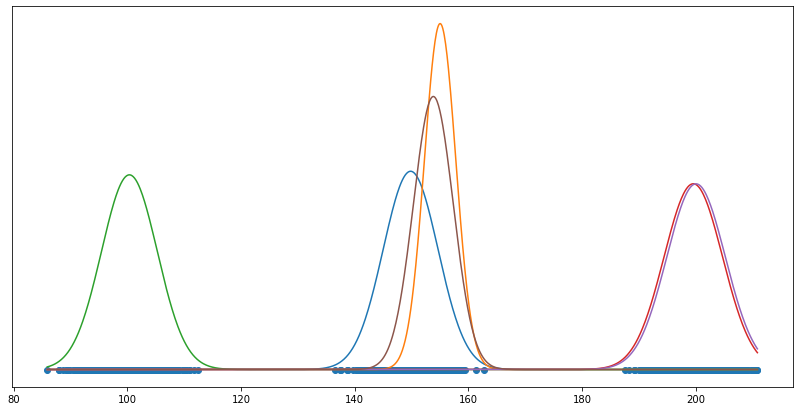

[0, 1, 2, 3, 4, 5] 0
[0, 1, 2, 3, 4, 5] 1
[0, 1, 2, 3, 4, 5] 2
[0, 1, 2, 3, 4, 5] 3
[0, 1, 2, 3, 4, 5] 4
[0, 1, 2, 3, 4, 5] 5
[0, 1, 2, 3, 4, 5] 6
[0, 1, 2, 4] 0
[0, 1, 2, 4] 1
[0, 1, 2, 4] 2
[0, 1, 2, 4] 3
[0, 1, 2, -1, 4] 4
[0, 1, 2, -1, 4] 5
[0, 1, 2, -1, 4, -1] 6
[0, 1, 4] 0
[0, 1, 4] 1
[0, 1, 4] 2
[0, 1, -1, 4] 3
[0, 1, -1, -1, 4] 4
[0, 1, -1, -1, 4] 5
[0, 1, -1, -1, 4, -1] 6
[0, 1, 4] 0
[0, 1, 4] 1
[0, 1, 4] 2
[0, 1, -1, 4] 3
[0, 1, -1, -1, 4] 4
[0, 1, -1, -1, 4] 5
[0, 1, -1, -1, 4, -1] 6
[0, 1, 4] 0
[0, 1, 4] 1
[0, 1, 4] 2
[0, 1, -1, 4] 3
[0, 1, -1, -1, 4] 4
[0, 1, -1, -1, 4] 5
[0, 1, -1, -1, 4, -1] 6
[0, 1, 4] 0
[0, 1, 4] 1
[0, 1, 4] 2
[0, 1, -1, 4] 3
[0, 1, -1, -1, 4] 4
[0, 1, -1, -1, 4] 5
[0, 1, -1, -1, 4, -1] 6
[0, 1, 4] 0
[0, 1, 4] 1
[0, 1, 4] 2
[0, 1, -1, 4] 3
[0, 1, -1, -1, 4] 4
[0, 1, -1, -1, 4] 5
[0, 1, -1, -1, 4, -1] 6
[0, 1, 4] 0
[0, 1, 4] 1
[0, 1, 4] 2
[0, 1, -1, 4] 3
[0, 1, -1, -1, 4] 4
[0, 1, -1, -1, 4] 5
[0, 1, -1, -1, 4, -1] 6
[0, 1, 4] 0
[0, 1, 4] 1
[0, 1, 4] 2


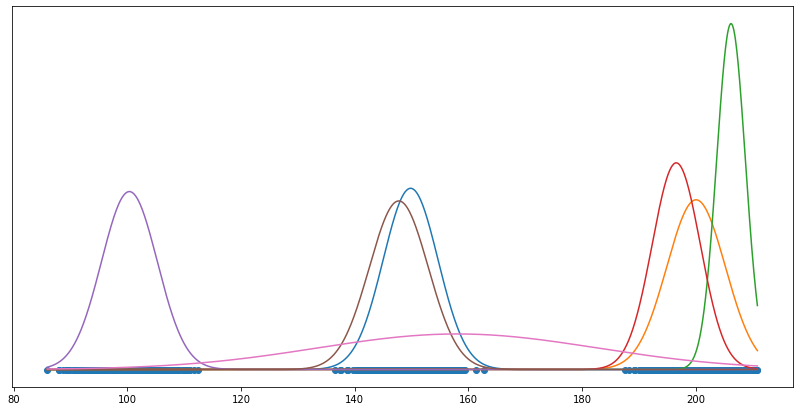

[0, 1, 3, 4, 5, 7] 0
[0, 1, 3, 4, 5, 7] 1
[0, 1, 3, 4, 5, 7] 2
[0, 1, -1, 3, 4, 5, 7] 3
[0, 1, -1, 3, 4, 5, 7] 4
[0, 1, -1, 3, 4, 5, 7] 5
[0, 1, -1, 3, 4, 5, 7] 6
[0, 1, -1, 3, 4, 5, -1, 7] 7
[0, 1, 3, 7] 0
[0, 1, 3, 7] 1
[0, 1, 3, 7] 2
[0, 1, -1, 3, 7] 3
[0, 1, -1, 3, 7] 4
[0, 1, -1, 3, -1, 7] 5
[0, 1, -1, 3, -1, -1, 7] 6
[0, 1, -1, 3, -1, -1, -1, 7] 7
[0, 1, 3, 7] 0
[0, 1, 3, 7] 1
[0, 1, 3, 7] 2
[0, 1, -1, 3, 7] 3
[0, 1, -1, 3, 7] 4
[0, 1, -1, 3, -1, 7] 5
[0, 1, -1, 3, -1, -1, 7] 6
[0, 1, -1, 3, -1, -1, -1, 7] 7
[0, 1, 3, 7] 0
[0, 1, 3, 7] 1
[0, 1, 3, 7] 2
[0, 1, -1, 3, 7] 3
[0, 1, -1, 3, 7] 4
[0, 1, -1, 3, -1, 7] 5
[0, 1, -1, 3, -1, -1, 7] 6
[0, 1, -1, 3, -1, -1, -1, 7] 7
[0, 1, 3] 0
[0, 1, 3] 1
[0, 1, 3] 2
[0, 1, -1, 3] 3
[0, 1, -1, 3] 4
[0, 1, -1, 3, -1] 5
[0, 1, -1, 3, -1, -1] 6
[0, 1, -1, 3, -1, -1, -1] 7
[0, 1, 3] 0
[0, 1, 3] 1
[0, 1, 3] 2
[0, 1, -1, 3] 3
[0, 1, -1, 3] 4
[0, 1, -1, 3, -1] 5
[0, 1, -1, 3, -1, -1] 6
[0, 1, -1, 3, -1, -1, -1] 7
[0, 1, 3] 0
[0, 1, 3] 1
[0, 1, 3] 2


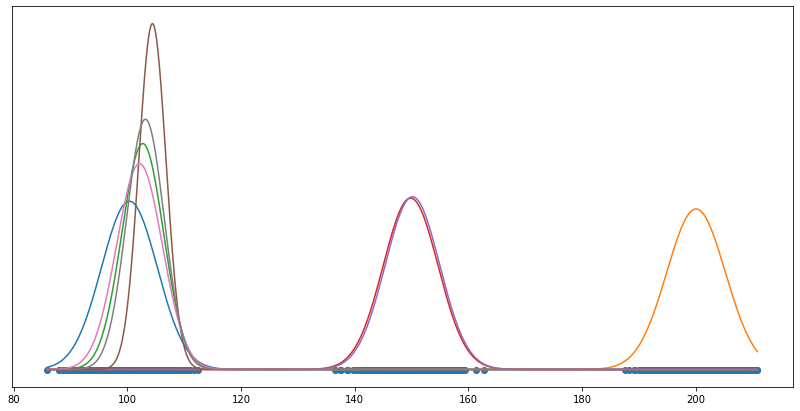

[1, 2, 4, 5, 6, 7, 8] 0
[-1, 1, 2, 4, 5, 6, 7, 8] 1
[-1, 1, 2, 4, 5, 6, 7, 8] 2
[-1, 1, 2, 4, 5, 6, 7, 8] 3
[-1, 1, 2, -1, 4, 5, 6, 7, 8] 4
[-1, 1, 2, -1, 4, 5, 6, 7, 8] 5
[-1, 1, 2, -1, 4, 5, 6, 7, 8] 6
[-1, 1, 2, -1, 4, 5, 6, 7, 8] 7
[-1, 1, 2, -1, 4, 5, 6, 7, 8] 8
[1, 4, 5, 7, 8] 0
[-1, 1, 4, 5, 7, 8] 1
[-1, 1, 4, 5, 7, 8] 2
[-1, 1, -1, 4, 5, 7, 8] 3
[-1, 1, -1, -1, 4, 5, 7, 8] 4
[-1, 1, -1, -1, 4, 5, 7, 8] 5
[-1, 1, -1, -1, 4, 5, 7, 8] 6
[-1, 1, -1, -1, 4, 5, -1, 7, 8] 7
[-1, 1, -1, -1, 4, 5, -1, 7, 8] 8
[1, 4, 5, 7, 8] 0
[-1, 1, 4, 5, 7, 8] 1
[-1, 1, 4, 5, 7, 8] 2
[-1, 1, -1, 4, 5, 7, 8] 3
[-1, 1, -1, -1, 4, 5, 7, 8] 4
[-1, 1, -1, -1, 4, 5, 7, 8] 5
[-1, 1, -1, -1, 4, 5, 7, 8] 6
[-1, 1, -1, -1, 4, 5, -1, 7, 8] 7
[-1, 1, -1, -1, 4, 5, -1, 7, 8] 8
[1, 4, 5, 7, 8] 0
[-1, 1, 4, 5, 7, 8] 1
[-1, 1, 4, 5, 7, 8] 2
[-1, 1, -1, 4, 5, 7, 8] 3
[-1, 1, -1, -1, 4, 5, 7, 8] 4
[-1, 1, -1, -1, 4, 5, 7, 8] 5
[-1, 1, -1, -1, 4, 5, 7, 8] 6
[-1, 1, -1, -1, 4, 5, -1, 7, 8] 7
[-1, 1, -1, -1, 4, 5, -1, 7,

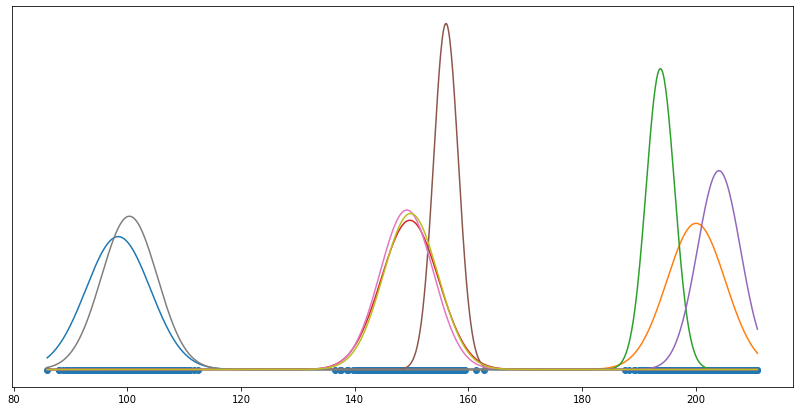

[0, 1, 2, 8, 9] 0
[0, 1, 2, 8, 9] 1
[0, 1, 2, 8, 9] 2
[0, 1, 2, 8, 9] 3
[0, 1, 2, -1, 8, 9] 4
[0, 1, 2, -1, -1, 8, 9] 5
[0, 1, 2, -1, -1, -1, 8, 9] 6
[0, 1, 2, -1, -1, -1, -1, 8, 9] 7
[0, 1, 2, -1, -1, -1, -1, -1, 8, 9] 8
[0, 1, 2, -1, -1, -1, -1, -1, 8, 9] 9
[0, 1, 2, 9] 0
[0, 1, 2, 9] 1
[0, 1, 2, 9] 2
[0, 1, 2, 9] 3
[0, 1, 2, -1, 9] 4
[0, 1, 2, -1, -1, 9] 5
[0, 1, 2, -1, -1, -1, 9] 6
[0, 1, 2, -1, -1, -1, -1, 9] 7
[0, 1, 2, -1, -1, -1, -1, -1, 9] 8
[0, 1, 2, -1, -1, -1, -1, -1, -1, 9] 9
[1, 2, 9] 0
[-1, 1, 2, 9] 1
[-1, 1, 2, 9] 2
[-1, 1, 2, 9] 3
[-1, 1, 2, -1, 9] 4
[-1, 1, 2, -1, -1, 9] 5
[-1, 1, 2, -1, -1, -1, 9] 6
[-1, 1, 2, -1, -1, -1, -1, 9] 7
[-1, 1, 2, -1, -1, -1, -1, -1, 9] 8
[-1, 1, 2, -1, -1, -1, -1, -1, -1, 9] 9
[1, 2, 9] 0
[-1, 1, 2, 9] 1
[-1, 1, 2, 9] 2
[-1, 1, 2, 9] 3
[-1, 1, 2, -1, 9] 4
[-1, 1, 2, -1, -1, 9] 5
[-1, 1, 2, -1, -1, -1, 9] 6
[-1, 1, 2, -1, -1, -1, -1, 9] 7
[-1, 1, 2, -1, -1, -1, -1, -1, 9] 8
[-1, 1, 2, -1, -1, -1, -1, -1, -1, 9] 9
[1, 2, 9] 0
[-1, 1, 2, 9] 

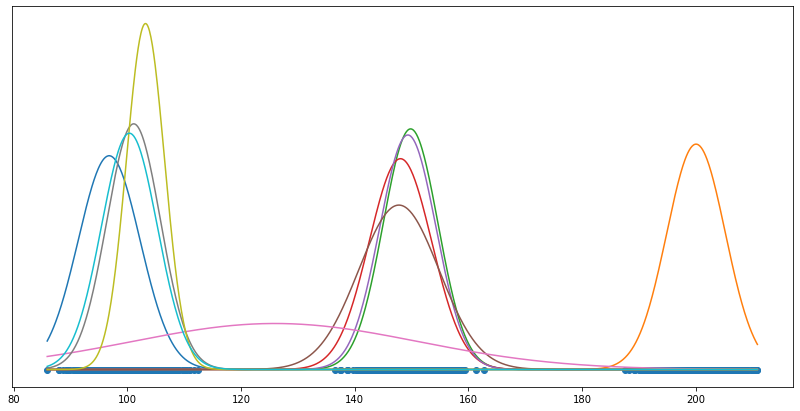

[1, 2, 3, 4, 6, 7, 8, 9] 0
[-1, 1, 2, 3, 4, 6, 7, 8, 9] 1
[-1, 1, 2, 3, 4, 6, 7, 8, 9] 2
[-1, 1, 2, 3, 4, 6, 7, 8, 9] 3
[-1, 1, 2, 3, 4, 6, 7, 8, 9] 4
[-1, 1, 2, 3, 4, 6, 7, 8, 9] 5
[-1, 1, 2, 3, 4, -1, 6, 7, 8, 9] 6
[-1, 1, 2, 3, 4, -1, 6, 7, 8, 9] 7
[-1, 1, 2, 3, 4, -1, 6, 7, 8, 9] 8
[-1, 1, 2, 3, 4, -1, 6, 7, 8, 9] 9
[-1, 1, 2, 3, 4, -1, 6, 7, 8, 9] 10
[1, 2, 3, 4, 8] 0
[-1, 1, 2, 3, 4, 8] 1
[-1, 1, 2, 3, 4, 8] 2
[-1, 1, 2, 3, 4, 8] 3
[-1, 1, 2, 3, 4, 8] 4
[-1, 1, 2, 3, 4, 8] 5
[-1, 1, 2, 3, 4, -1, 8] 6
[-1, 1, 2, 3, 4, -1, -1, 8] 7
[-1, 1, 2, 3, 4, -1, -1, -1, 8] 8
[-1, 1, 2, 3, 4, -1, -1, -1, 8] 9
[-1, 1, 2, 3, 4, -1, -1, -1, 8, -1] 10
[1, 2, 3, 4, 8] 0
[-1, 1, 2, 3, 4, 8] 1
[-1, 1, 2, 3, 4, 8] 2
[-1, 1, 2, 3, 4, 8] 3
[-1, 1, 2, 3, 4, 8] 4
[-1, 1, 2, 3, 4, 8] 5
[-1, 1, 2, 3, 4, -1, 8] 6
[-1, 1, 2, 3, 4, -1, -1, 8] 7
[-1, 1, 2, 3, 4, -1, -1, -1, 8] 8
[-1, 1, 2, 3, 4, -1, -1, -1, 8] 9
[-1, 1, 2, 3, 4, -1, -1, -1, 8, -1] 10
[1, 2, 3, 4, 8] 0
[-1, 1, 2, 3, 4, 8] 1
[-1, 1, 2, 3, 4, 8] 

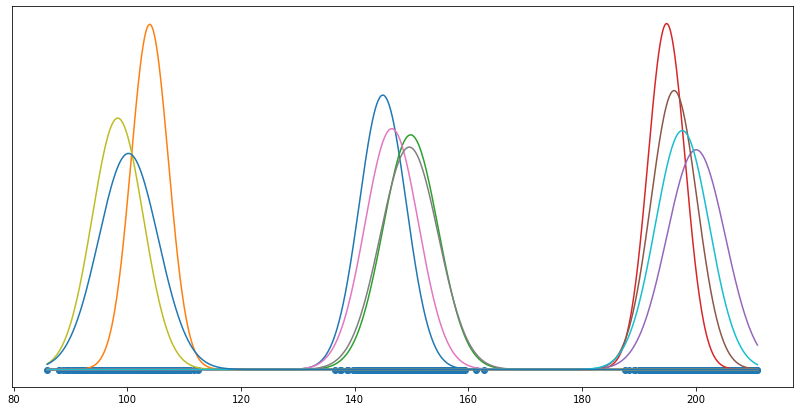

[0, 1, 2, 3, 4, 6, 7, 8, 10, 11] 0
[0, 1, 2, 3, 4, 6, 7, 8, 10, 11] 1
[0, 1, 2, 3, 4, 6, 7, 8, 10, 11] 2
[0, 1, 2, 3, 4, 6, 7, 8, 10, 11] 3
[0, 1, 2, 3, 4, 6, 7, 8, 10, 11] 4
[0, 1, 2, 3, 4, 6, 7, 8, 10, 11] 5
[0, 1, 2, 3, 4, -1, 6, 7, 8, 10, 11] 6
[0, 1, 2, 3, 4, -1, 6, 7, 8, 10, 11] 7
[0, 1, 2, 3, 4, -1, 6, 7, 8, 10, 11] 8
[0, 1, 2, 3, 4, -1, 6, 7, 8, 10, 11] 9
[0, 1, 2, 3, 4, -1, 6, 7, 8, -1, 10, 11] 10
[0, 1, 2, 3, 4, -1, 6, 7, 8, -1, 10, 11] 11
[1, 2, 3, 6, 7, 8] 0
[-1, 1, 2, 3, 6, 7, 8] 1
[-1, 1, 2, 3, 6, 7, 8] 2
[-1, 1, 2, 3, 6, 7, 8] 3
[-1, 1, 2, 3, 6, 7, 8] 4
[-1, 1, 2, 3, -1, 6, 7, 8] 5
[-1, 1, 2, 3, -1, -1, 6, 7, 8] 6
[-1, 1, 2, 3, -1, -1, 6, 7, 8] 7
[-1, 1, 2, 3, -1, -1, 6, 7, 8] 8
[-1, 1, 2, 3, -1, -1, 6, 7, 8] 9
[-1, 1, 2, 3, -1, -1, 6, 7, 8, -1] 10
[-1, 1, 2, 3, -1, -1, 6, 7, 8, -1, -1] 11
[2, 3, 6, 7, 8] 0
[-1, 2, 3, 6, 7, 8] 1
[-1, -1, 2, 3, 6, 7, 8] 2
[-1, -1, 2, 3, 6, 7, 8] 3
[-1, -1, 2, 3, 6, 7, 8] 4
[-1, -1, 2, 3, -1, 6, 7, 8] 5
[-1, -1, 2, 3, -1, -1, 6, 7, 8] 6
[-

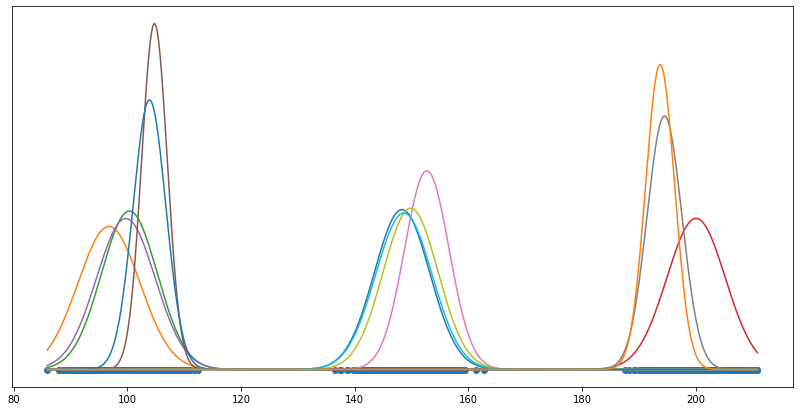

[0, 1, 3, 4, 5, 6, 8, 10] 0
[0, 1, 3, 4, 5, 6, 8, 10] 1
[0, 1, 3, 4, 5, 6, 8, 10] 2
[0, 1, -1, 3, 4, 5, 6, 8, 10] 3
[0, 1, -1, 3, 4, 5, 6, 8, 10] 4
[0, 1, -1, 3, 4, 5, 6, 8, 10] 5
[0, 1, -1, 3, 4, 5, 6, 8, 10] 6
[0, 1, -1, 3, 4, 5, 6, 8, 10] 7
[0, 1, -1, 3, 4, 5, 6, -1, 8, 10] 8
[0, 1, -1, 3, 4, 5, 6, -1, 8, 10] 9
[0, 1, -1, 3, 4, 5, 6, -1, 8, -1, 10] 10
[0, 1, -1, 3, 4, 5, 6, -1, 8, -1, 10] 11
[0, 1, -1, 3, 4, 5, 6, -1, 8, -1, 10, -1] 12
[0, 1, 4, 5, 6, 8] 0
[0, 1, 4, 5, 6, 8] 1
[0, 1, 4, 5, 6, 8] 2
[0, 1, -1, 4, 5, 6, 8] 3
[0, 1, -1, -1, 4, 5, 6, 8] 4
[0, 1, -1, -1, 4, 5, 6, 8] 5
[0, 1, -1, -1, 4, 5, 6, 8] 6
[0, 1, -1, -1, 4, 5, 6, 8] 7
[0, 1, -1, -1, 4, 5, 6, -1, 8] 8
[0, 1, -1, -1, 4, 5, 6, -1, 8] 9
[0, 1, -1, -1, 4, 5, 6, -1, 8, -1] 10
[0, 1, -1, -1, 4, 5, 6, -1, 8, -1, -1] 11
[0, 1, -1, -1, 4, 5, 6, -1, 8, -1, -1, -1] 12
[0, 1, 4, 5, 6] 0
[0, 1, 4, 5, 6] 1
[0, 1, 4, 5, 6] 2
[0, 1, -1, 4, 5, 6] 3
[0, 1, -1, -1, 4, 5, 6] 4
[0, 1, -1, -1, 4, 5, 6] 5
[0, 1, -1, -1, 4, 5, 6] 6
[0, 1, 

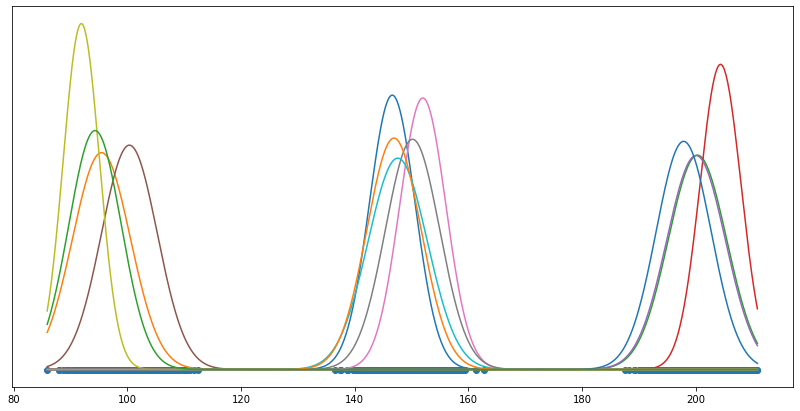

[0, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13] 0
[0, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13] 1
[0, -1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13] 2
[0, -1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13] 3
[0, -1, 2, -1, 4, 5, 6, 7, 8, 9, 11, 12, 13] 4
[0, -1, 2, -1, 4, 5, 6, 7, 8, 9, 11, 12, 13] 5
[0, -1, 2, -1, 4, 5, 6, 7, 8, 9, 11, 12, 13] 6
[0, -1, 2, -1, 4, 5, 6, 7, 8, 9, 11, 12, 13] 7
[0, -1, 2, -1, 4, 5, 6, 7, 8, 9, 11, 12, 13] 8
[0, -1, 2, -1, 4, 5, 6, 7, 8, 9, 11, 12, 13] 9
[0, -1, 2, -1, 4, 5, 6, 7, 8, 9, 11, 12, 13] 10
[0, -1, 2, -1, 4, 5, 6, 7, 8, 9, -1, 11, 12, 13] 11
[0, -1, 2, -1, 4, 5, 6, 7, 8, 9, -1, 11, 12, 13] 12
[0, -1, 2, -1, 4, 5, 6, 7, 8, 9, -1, 11, 12, 13] 13
[0, 2, 4, 9, 11, 12] 0
[0, 2, 4, 9, 11, 12] 1
[0, -1, 2, 4, 9, 11, 12] 2
[0, -1, 2, 4, 9, 11, 12] 3
[0, -1, 2, -1, 4, 9, 11, 12] 4
[0, -1, 2, -1, 4, 9, 11, 12] 5
[0, -1, 2, -1, 4, -1, 9, 11, 12] 6
[0, -1, 2, -1, 4, -1, -1, 9, 11, 12] 7
[0, -1, 2, -1, 4, -1, -1, -1, 9, 11, 12] 8
[0, -1, 2, -1, 4, -1, -1, -1, -1, 9, 11, 12] 9
[0, -1, 2, -1, 4, -1, -1

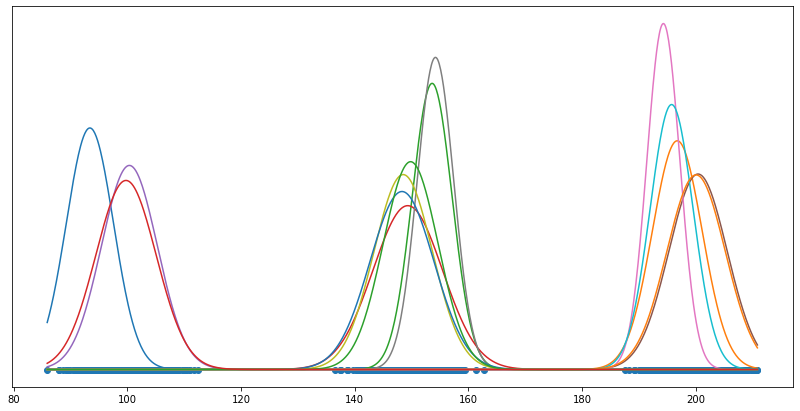

[0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14] 0
[0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14] 1
[0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14] 2
[0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14] 3
[0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14] 4
[0, 1, 2, 3, -1, 5, 6, 7, 10, 11, 12, 13, 14] 5
[0, 1, 2, 3, -1, 5, 6, 7, 10, 11, 12, 13, 14] 6
[0, 1, 2, 3, -1, 5, 6, 7, 10, 11, 12, 13, 14] 7
[0, 1, 2, 3, -1, 5, 6, 7, 10, 11, 12, 13, 14] 8
[0, 1, 2, 3, -1, 5, 6, 7, -1, 10, 11, 12, 13, 14] 9
[0, 1, 2, 3, -1, 5, 6, 7, -1, -1, 10, 11, 12, 13, 14] 10
[0, 1, 2, 3, -1, 5, 6, 7, -1, -1, 10, 11, 12, 13, 14] 11
[0, 1, 2, 3, -1, 5, 6, 7, -1, -1, 10, 11, 12, 13, 14] 12
[0, 1, 2, 3, -1, 5, 6, 7, -1, -1, 10, 11, 12, 13, 14] 13
[0, 1, 2, 3, -1, 5, 6, 7, -1, -1, 10, 11, 12, 13, 14] 14
[0, 5, 7, 12, 14] 0
[0, 5, 7, 12, 14] 1
[0, -1, 5, 7, 12, 14] 2
[0, -1, -1, 5, 7, 12, 14] 3
[0, -1, -1, -1, 5, 7, 12, 14] 4
[0, -1, -1, -1, -1, 5, 7, 12, 14] 5
[0, -1, -1, -1, -1, 5, 7, 12, 14] 6
[0, -1, -1, -1, -1, 5, -1, 7, 12, 14] 7
[0, -1, -1, -1,

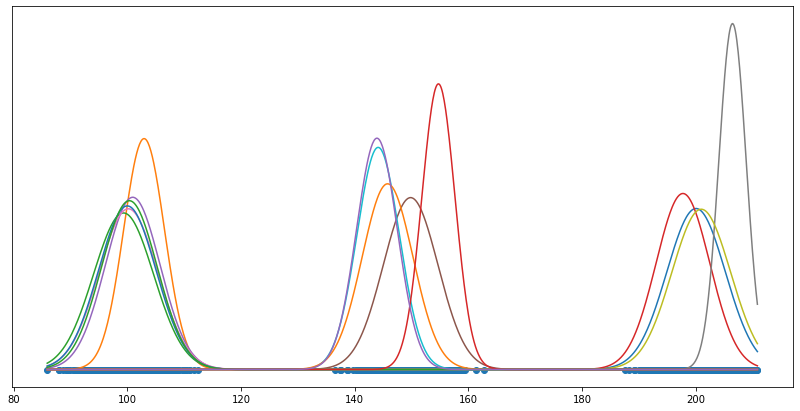

best model:


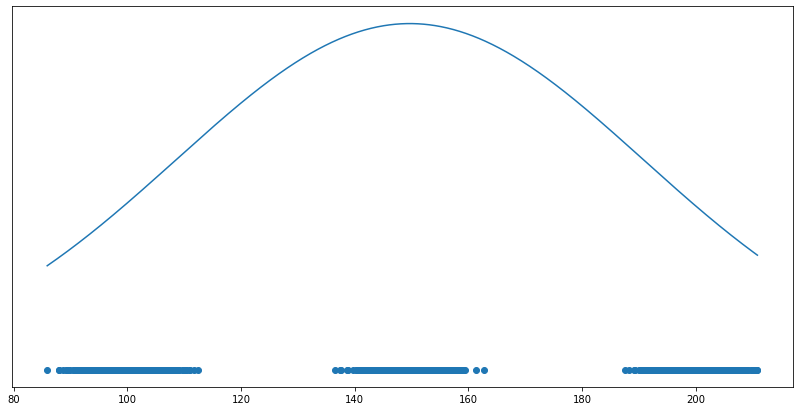

In [13]:
sel_plt(sample_x)

[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
1 599.0248904869825


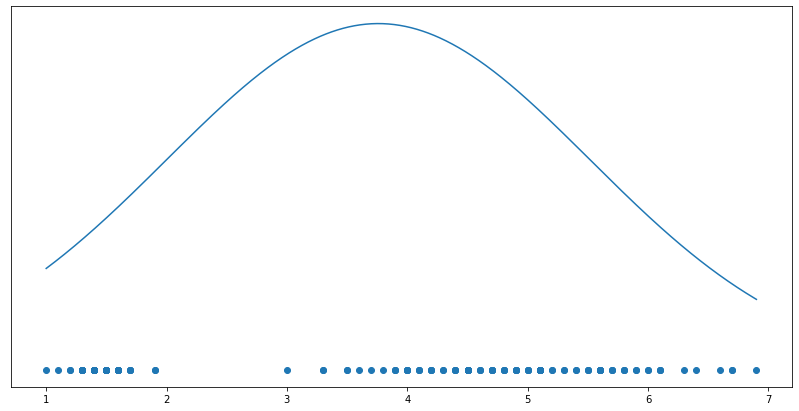

This is the new best model according to aic!
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
2 411.07085197276047


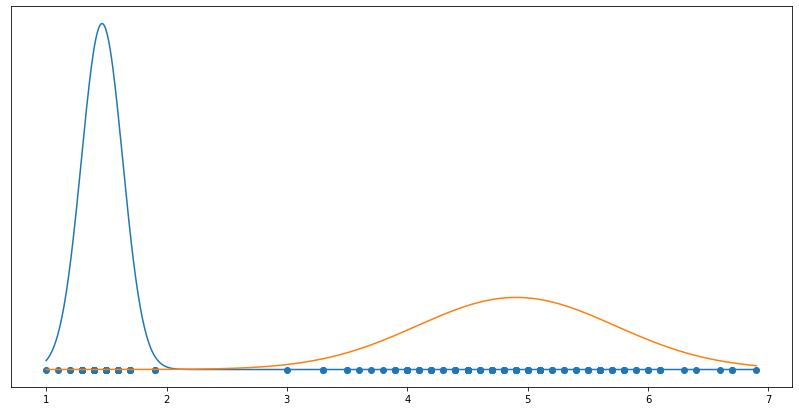

[0, 1, 2] 0
[0, 1, 2] 1
[0, 1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
[0, 2] 0
[0, 2] 1
[0, -1, 2] 2
3 417.07084997106807


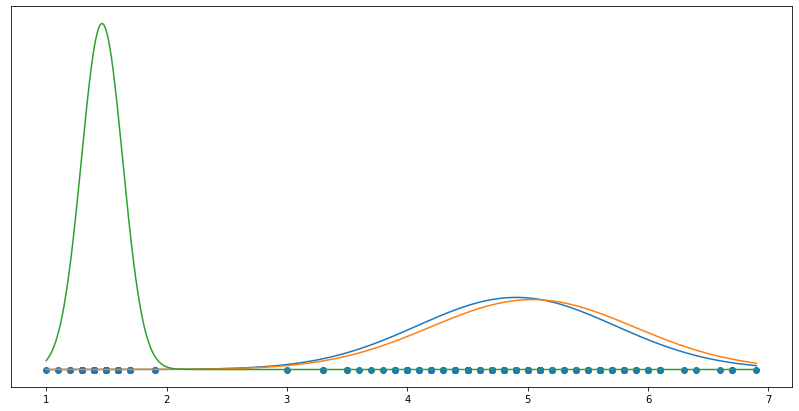

[1, 2, 3] 0
[-1, 1, 2, 3] 1
[-1, 1, 2, 3] 2
[-1, 1, 2, 3] 3
[1, 2, 3] 0
[-1, 1, 2, 3] 1
[-1, 1, 2, 3] 2
[-1, 1, 2, 3] 3
[1, 2, 3] 0
[-1, 1, 2, 3] 1
[-1, 1, 2, 3] 2
[-1, 1, 2, 3] 3
[1, 2, 3] 0
[-1, 1, 2, 3] 1
[-1, 1, 2, 3] 2
[-1, 1, 2, 3] 3
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[-1, 1, 2] 3
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[-1, 1, 2] 3
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[-1, 1, 2] 3
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[-1, 1, 2] 3
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[-1, 1, 2] 3
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[-1, 1, 2] 3
4 423.0708479162663


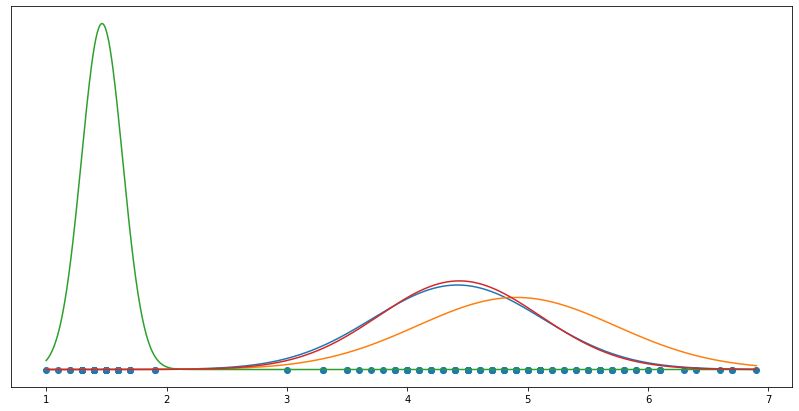

[0, 1, 2, 3] 0
[0, 1, 2, 3] 1
[0, 1, 2, 3] 2
[0, 1, 2, 3] 3
[0, 1, 2, 3] 4
[1, 2, 3] 0
[-1, 1, 2, 3] 1
[-1, 1, 2, 3] 2
[-1, 1, 2, 3] 3
[-1, 1, 2, 3] 4
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[-1, 1, 2] 3
[-1, 1, 2, -1] 4
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[-1, 1, 2] 3
[-1, 1, 2, -1] 4
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[-1, 1, 2] 3
[-1, 1, 2, -1] 4
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[-1, 1, 2] 3
[-1, 1, 2, -1] 4
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[-1, 1, 2] 3
[-1, 1, 2, -1] 4
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[-1, 1, 2] 3
[-1, 1, 2, -1] 4
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[-1, 1, 2] 3
[-1, 1, 2, -1] 4
[1, 2] 0
[-1, 1, 2] 1
[-1, 1, 2] 2
[-1, 1, 2] 3
[-1, 1, 2, -1] 4
5 429.0708459666984


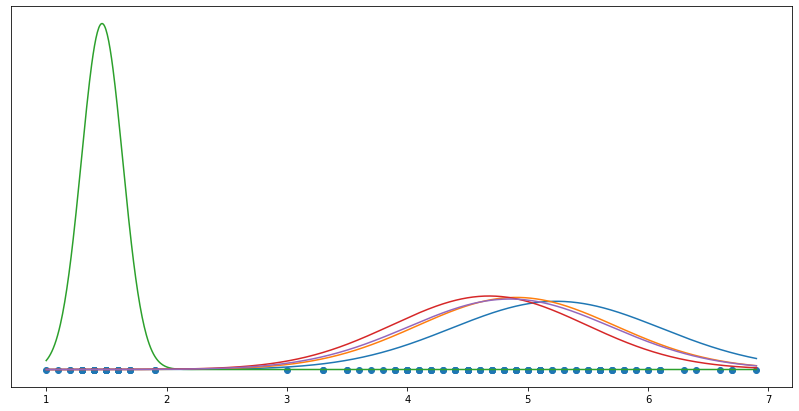

[0, 2, 4, 5] 0
[0, 2, 4, 5] 1
[0, -1, 2, 4, 5] 2
[0, -1, 2, 4, 5] 3
[0, -1, 2, -1, 4, 5] 4
[0, -1, 2, -1, 4, 5] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
6 433.559546816041


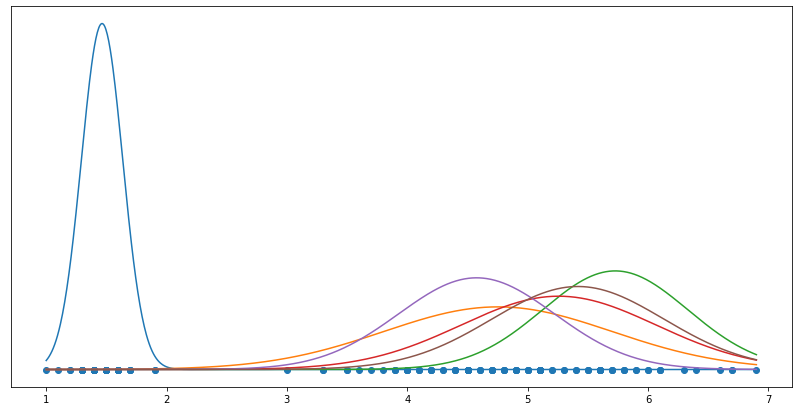

[0, 1, 2, 6] 0
[0, 1, 2, 6] 1
[0, 1, 2, 6] 2
[0, 1, 2, 6] 3
[0, 1, 2, -1, 6] 4
[0, 1, 2, -1, -1, 6] 5
[0, 1, 2, -1, -1, -1, 6] 6
[1, 6] 0
[-1, 1, 6] 1
[-1, 1, 6] 2
[-1, 1, -1, 6] 3
[-1, 1, -1, -1, 6] 4
[-1, 1, -1, -1, -1, 6] 5
[-1, 1, -1, -1, -1, -1, 6] 6
[1, 6] 0
[-1, 1, 6] 1
[-1, 1, 6] 2
[-1, 1, -1, 6] 3
[-1, 1, -1, -1, 6] 4
[-1, 1, -1, -1, -1, 6] 5
[-1, 1, -1, -1, -1, -1, 6] 6
[1, 6] 0
[-1, 1, 6] 1
[-1, 1, 6] 2
[-1, 1, -1, 6] 3
[-1, 1, -1, -1, 6] 4
[-1, 1, -1, -1, -1, 6] 5
[-1, 1, -1, -1, -1, -1, 6] 6
[1, 6] 0
[-1, 1, 6] 1
[-1, 1, 6] 2
[-1, 1, -1, 6] 3
[-1, 1, -1, -1, 6] 4
[-1, 1, -1, -1, -1, 6] 5
[-1, 1, -1, -1, -1, -1, 6] 6
[1, 6] 0
[-1, 1, 6] 1
[-1, 1, 6] 2
[-1, 1, -1, 6] 3
[-1, 1, -1, -1, 6] 4
[-1, 1, -1, -1, -1, 6] 5
[-1, 1, -1, -1, -1, -1, 6] 6
[1, 6] 0
[-1, 1, 6] 1
[-1, 1, 6] 2
[-1, 1, -1, 6] 3
[-1, 1, -1, -1, 6] 4
[-1, 1, -1, -1, -1, 6] 5
[-1, 1, -1, -1, -1, -1, 6] 6
[1, 6] 0
[-1, 1, 6] 1
[-1, 1, 6] 2
[-1, 1, -1, 6] 3
[-1, 1, -1, -1, 6] 4
[-1, 1, -1, -1, -1, 6] 5
[-1, 1, -1,

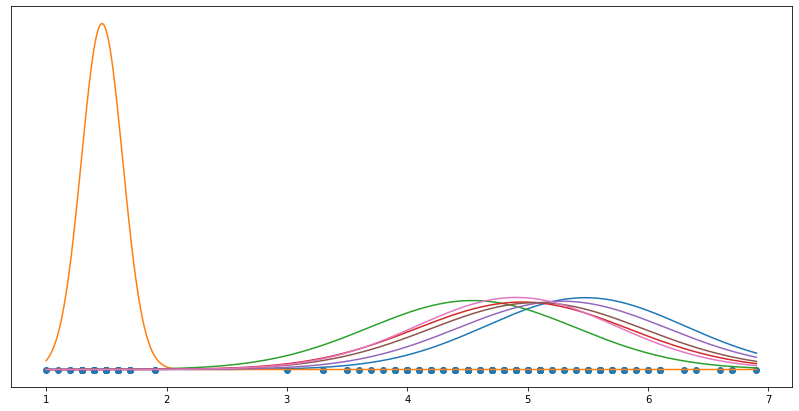

[0, 2, 3, 4, 5] 0
[0, 2, 3, 4, 5] 1
[0, -1, 2, 3, 4, 5] 2
[0, -1, 2, 3, 4, 5] 3
[0, -1, 2, 3, 4, 5] 4
[0, -1, 2, 3, 4, 5] 5
[0, -1, 2, 3, 4, 5] 6
[0, -1, 2, 3, 4, 5, -1] 7
[0, 2, 4, 5] 0
[0, 2, 4, 5] 1
[0, -1, 2, 4, 5] 2
[0, -1, 2, 4, 5] 3
[0, -1, 2, -1, 4, 5] 4
[0, -1, 2, -1, 4, 5] 5
[0, -1, 2, -1, 4, 5] 6
[0, -1, 2, -1, 4, 5, -1] 7
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, -1, 2, -1, 4, -1] 6
[0, -1, 2, -1, 4, -1, -1] 7
[0, 4] 0
[0, 4] 1
[0, -1, 4] 2
[0, -1, -1, 4] 3
[0, -1, -1, -1, 4] 4
[0, -1, -1, -1, 4] 5
[0, -1, -1, -1, 4, -1] 6
[0, -1, -1, -1, 4, -1, -1] 7
[0, 4] 0
[0, 4] 1
[0, -1, 4] 2
[0, -1, -1, 4] 3
[0, -1, -1, -1, 4] 4
[0, -1, -1, -1, 4] 5
[0, -1, -1, -1, 4, -1] 6
[0, -1, -1, -1, 4, -1, -1] 7
[0, 4] 0
[0, 4] 1
[0, -1, 4] 2
[0, -1, -1, 4] 3
[0, -1, -1, -1, 4] 4
[0, -1, -1, -1, 4] 5
[0, -1, -1, -1, 4, -1] 6
[0, -1, -1, -1, 4, -1, -1] 7
[0, 4] 0
[0, 4] 1
[0, -1, 4] 2
[0, -1, -1, 4] 3
[0, -1, -1, -1, 4] 4
[0, -1, -1, -1,

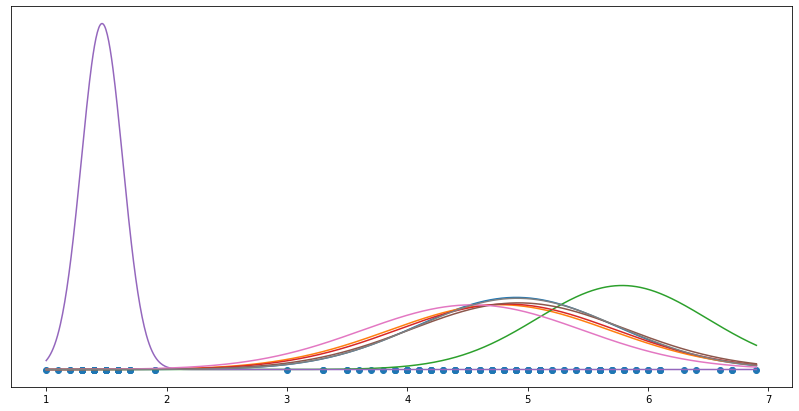

[1, 2, 4, 5, 6] 0
[-1, 1, 2, 4, 5, 6] 1
[-1, 1, 2, 4, 5, 6] 2
[-1, 1, 2, 4, 5, 6] 3
[-1, 1, 2, -1, 4, 5, 6] 4
[-1, 1, 2, -1, 4, 5, 6] 5
[-1, 1, 2, -1, 4, 5, 6] 6
[-1, 1, 2, -1, 4, 5, 6] 7
[-1, 1, 2, -1, 4, 5, 6, -1] 8
[2, 4, 5, 6] 0
[-1, 2, 4, 5, 6] 1
[-1, -1, 2, 4, 5, 6] 2
[-1, -1, 2, 4, 5, 6] 3
[-1, -1, 2, -1, 4, 5, 6] 4
[-1, -1, 2, -1, 4, 5, 6] 5
[-1, -1, 2, -1, 4, 5, 6] 6
[-1, -1, 2, -1, 4, 5, 6] 7
[-1, -1, 2, -1, 4, 5, 6, -1] 8
[2, 5, 6] 0
[-1, 2, 5, 6] 1
[-1, -1, 2, 5, 6] 2
[-1, -1, 2, 5, 6] 3
[-1, -1, 2, -1, 5, 6] 4
[-1, -1, 2, -1, -1, 5, 6] 5
[-1, -1, 2, -1, -1, 5, 6] 6
[-1, -1, 2, -1, -1, 5, 6] 7
[-1, -1, 2, -1, -1, 5, 6, -1] 8
[5, 6] 0
[-1, 5, 6] 1
[-1, -1, 5, 6] 2
[-1, -1, -1, 5, 6] 3
[-1, -1, -1, -1, 5, 6] 4
[-1, -1, -1, -1, -1, 5, 6] 5
[-1, -1, -1, -1, -1, 5, 6] 6
[-1, -1, -1, -1, -1, 5, 6] 7
[-1, -1, -1, -1, -1, 5, 6, -1] 8
[5, 6] 0
[-1, 5, 6] 1
[-1, -1, 5, 6] 2
[-1, -1, -1, 5, 6] 3
[-1, -1, -1, -1, 5, 6] 4
[-1, -1, -1, -1, -1, 5, 6] 5
[-1, -1, -1, -1, -1, 5, 6] 6
[-1, -1

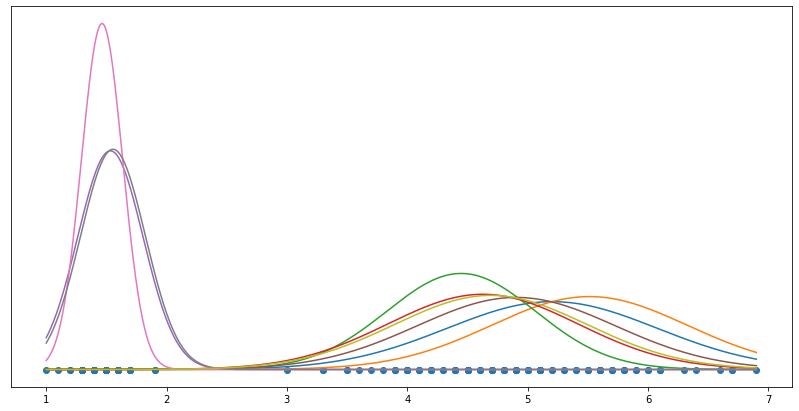

[0, 1, 2, 4, 5, 9] 0
[0, 1, 2, 4, 5, 9] 1
[0, 1, 2, 4, 5, 9] 2
[0, 1, 2, 4, 5, 9] 3
[0, 1, 2, -1, 4, 5, 9] 4
[0, 1, 2, -1, 4, 5, 9] 5
[0, 1, 2, -1, 4, 5, 9] 6
[0, 1, 2, -1, 4, 5, -1, 9] 7
[0, 1, 2, -1, 4, 5, -1, -1, 9] 8
[0, 1, 2, -1, 4, 5, -1, -1, -1, 9] 9
[0, 1, 5] 0
[0, 1, 5] 1
[0, 1, 5] 2
[0, 1, -1, 5] 3
[0, 1, -1, -1, 5] 4
[0, 1, -1, -1, -1, 5] 5
[0, 1, -1, -1, -1, 5] 6
[0, 1, -1, -1, -1, 5, -1] 7
[0, 1, -1, -1, -1, 5, -1, -1] 8
[0, 1, -1, -1, -1, 5, -1, -1, -1] 9
[0, 1, 5] 0
[0, 1, 5] 1
[0, 1, 5] 2
[0, 1, -1, 5] 3
[0, 1, -1, -1, 5] 4
[0, 1, -1, -1, -1, 5] 5
[0, 1, -1, -1, -1, 5] 6
[0, 1, -1, -1, -1, 5, -1] 7
[0, 1, -1, -1, -1, 5, -1, -1] 8
[0, 1, -1, -1, -1, 5, -1, -1, -1] 9
[0, 1, 5] 0
[0, 1, 5] 1
[0, 1, 5] 2
[0, 1, -1, 5] 3
[0, 1, -1, -1, 5] 4
[0, 1, -1, -1, -1, 5] 5
[0, 1, -1, -1, -1, 5] 6
[0, 1, -1, -1, -1, 5, -1] 7
[0, 1, -1, -1, -1, 5, -1, -1] 8
[0, 1, -1, -1, -1, 5, -1, -1, -1] 9
[1, 5] 0
[-1, 1, 5] 1
[-1, 1, 5] 2
[-1, 1, -1, 5] 3
[-1, 1, -1, -1, 5] 4
[-1, 1, -1, -1, -1, 5

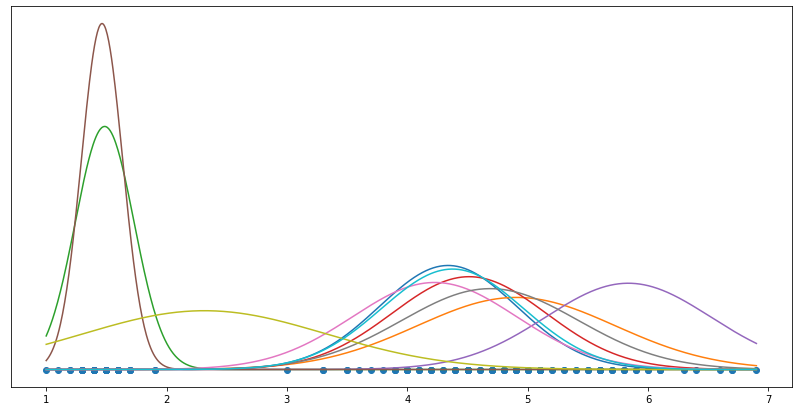

[1, 2, 4, 7, 10] 0
[-1, 1, 2, 4, 7, 10] 1
[-1, 1, 2, 4, 7, 10] 2
[-1, 1, 2, 4, 7, 10] 3
[-1, 1, 2, -1, 4, 7, 10] 4
[-1, 1, 2, -1, 4, 7, 10] 5
[-1, 1, 2, -1, 4, -1, 7, 10] 6
[-1, 1, 2, -1, 4, -1, -1, 7, 10] 7
[-1, 1, 2, -1, 4, -1, -1, 7, 10] 8
[-1, 1, 2, -1, 4, -1, -1, 7, -1, 10] 9
[-1, 1, 2, -1, 4, -1, -1, 7, -1, -1, 10] 10
[1, 2, 7, 10] 0
[-1, 1, 2, 7, 10] 1
[-1, 1, 2, 7, 10] 2
[-1, 1, 2, 7, 10] 3
[-1, 1, 2, -1, 7, 10] 4
[-1, 1, 2, -1, -1, 7, 10] 5
[-1, 1, 2, -1, -1, -1, 7, 10] 6
[-1, 1, 2, -1, -1, -1, -1, 7, 10] 7
[-1, 1, 2, -1, -1, -1, -1, 7, 10] 8
[-1, 1, 2, -1, -1, -1, -1, 7, -1, 10] 9
[-1, 1, 2, -1, -1, -1, -1, 7, -1, -1, 10] 10
[1, 7, 10] 0
[-1, 1, 7, 10] 1
[-1, 1, 7, 10] 2
[-1, 1, -1, 7, 10] 3
[-1, 1, -1, -1, 7, 10] 4
[-1, 1, -1, -1, -1, 7, 10] 5
[-1, 1, -1, -1, -1, -1, 7, 10] 6
[-1, 1, -1, -1, -1, -1, -1, 7, 10] 7
[-1, 1, -1, -1, -1, -1, -1, 7, 10] 8
[-1, 1, -1, -1, -1, -1, -1, 7, -1, 10] 9
[-1, 1, -1, -1, -1, -1, -1, 7, -1, -1, 10] 10
[1, 7, 10] 0
[-1, 1, 7, 10] 1
[-1, 1, 7, 

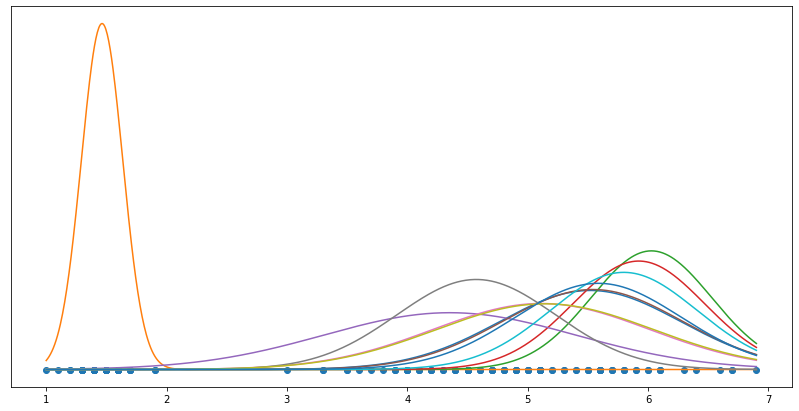

[0, 1, 2, 9, 10] 0
[0, 1, 2, 9, 10] 1
[0, 1, 2, 9, 10] 2
[0, 1, 2, 9, 10] 3
[0, 1, 2, -1, 9, 10] 4
[0, 1, 2, -1, -1, 9, 10] 5
[0, 1, 2, -1, -1, -1, 9, 10] 6
[0, 1, 2, -1, -1, -1, -1, 9, 10] 7
[0, 1, 2, -1, -1, -1, -1, -1, 9, 10] 8
[0, 1, 2, -1, -1, -1, -1, -1, -1, 9, 10] 9
[0, 1, 2, -1, -1, -1, -1, -1, -1, 9, 10] 10
[0, 1, 2, -1, -1, -1, -1, -1, -1, 9, 10] 11
[0, 9] 0
[0, 9] 1
[0, -1, 9] 2
[0, -1, -1, 9] 3
[0, -1, -1, -1, 9] 4
[0, -1, -1, -1, -1, 9] 5
[0, -1, -1, -1, -1, -1, 9] 6
[0, -1, -1, -1, -1, -1, -1, 9] 7
[0, -1, -1, -1, -1, -1, -1, -1, 9] 8
[0, -1, -1, -1, -1, -1, -1, -1, -1, 9] 9
[0, -1, -1, -1, -1, -1, -1, -1, -1, 9] 10
[0, -1, -1, -1, -1, -1, -1, -1, -1, 9, -1] 11
[0, 9] 0
[0, 9] 1
[0, -1, 9] 2
[0, -1, -1, 9] 3
[0, -1, -1, -1, 9] 4
[0, -1, -1, -1, -1, 9] 5
[0, -1, -1, -1, -1, -1, 9] 6
[0, -1, -1, -1, -1, -1, -1, 9] 7
[0, -1, -1, -1, -1, -1, -1, -1, 9] 8
[0, -1, -1, -1, -1, -1, -1, -1, -1, 9] 9
[0, -1, -1, -1, -1, -1, -1, -1, -1, 9] 10
[0, -1, -1, -1, -1, -1, -1, -1, -1, 9, -

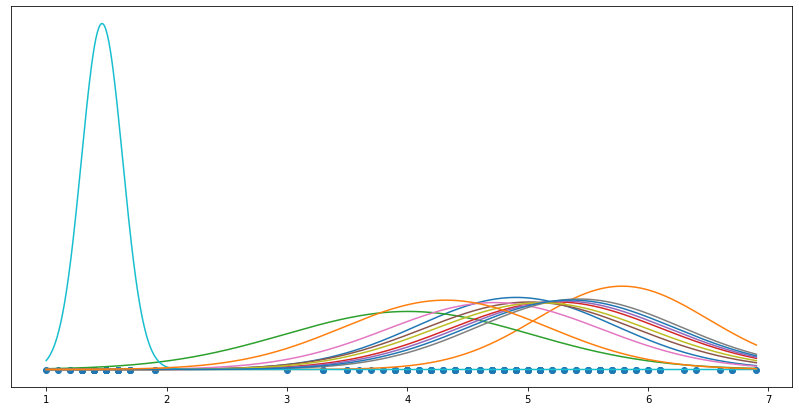

[1, 2, 9, 11, 12] 0
[-1, 1, 2, 9, 11, 12] 1
[-1, 1, 2, 9, 11, 12] 2
[-1, 1, 2, 9, 11, 12] 3
[-1, 1, 2, -1, 9, 11, 12] 4
[-1, 1, 2, -1, -1, 9, 11, 12] 5
[-1, 1, 2, -1, -1, -1, 9, 11, 12] 6
[-1, 1, 2, -1, -1, -1, -1, 9, 11, 12] 7
[-1, 1, 2, -1, -1, -1, -1, -1, 9, 11, 12] 8
[-1, 1, 2, -1, -1, -1, -1, -1, -1, 9, 11, 12] 9
[-1, 1, 2, -1, -1, -1, -1, -1, -1, 9, 11, 12] 10
[-1, 1, 2, -1, -1, -1, -1, -1, -1, 9, -1, 11, 12] 11
[-1, 1, 2, -1, -1, -1, -1, -1, -1, 9, -1, 11, 12] 12
[1, 2, 9, 12] 0
[-1, 1, 2, 9, 12] 1
[-1, 1, 2, 9, 12] 2
[-1, 1, 2, 9, 12] 3
[-1, 1, 2, -1, 9, 12] 4
[-1, 1, 2, -1, -1, 9, 12] 5
[-1, 1, 2, -1, -1, -1, 9, 12] 6
[-1, 1, 2, -1, -1, -1, -1, 9, 12] 7
[-1, 1, 2, -1, -1, -1, -1, -1, 9, 12] 8
[-1, 1, 2, -1, -1, -1, -1, -1, -1, 9, 12] 9
[-1, 1, 2, -1, -1, -1, -1, -1, -1, 9, 12] 10
[-1, 1, 2, -1, -1, -1, -1, -1, -1, 9, -1, 12] 11
[-1, 1, 2, -1, -1, -1, -1, -1, -1, 9, -1, -1, 12] 12
[1, 2, 12] 0
[-1, 1, 2, 12] 1
[-1, 1, 2, 12] 2
[-1, 1, 2, 12] 3
[-1, 1, 2, -1, 12] 4
[-1, 1, 2, -1

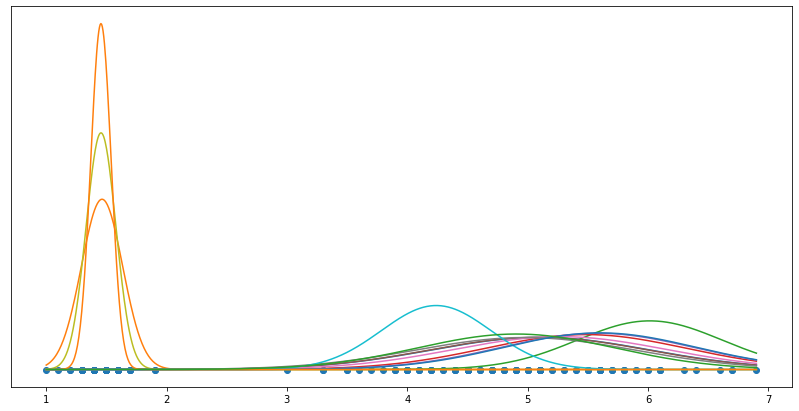

[0, 2, 7, 8, 10] 0
[0, 2, 7, 8, 10] 1
[0, -1, 2, 7, 8, 10] 2
[0, -1, 2, 7, 8, 10] 3
[0, -1, 2, -1, 7, 8, 10] 4
[0, -1, 2, -1, -1, 7, 8, 10] 5
[0, -1, 2, -1, -1, -1, 7, 8, 10] 6
[0, -1, 2, -1, -1, -1, -1, 7, 8, 10] 7
[0, -1, 2, -1, -1, -1, -1, 7, 8, 10] 8
[0, -1, 2, -1, -1, -1, -1, 7, 8, 10] 9
[0, -1, 2, -1, -1, -1, -1, 7, 8, -1, 10] 10
[0, -1, 2, -1, -1, -1, -1, 7, 8, -1, 10] 11
[0, -1, 2, -1, -1, -1, -1, 7, 8, -1, 10, -1] 12
[0, -1, 2, -1, -1, -1, -1, 7, 8, -1, 10, -1, -1] 13
[0, 7, 8] 0
[0, 7, 8] 1
[0, -1, 7, 8] 2
[0, -1, -1, 7, 8] 3
[0, -1, -1, -1, 7, 8] 4
[0, -1, -1, -1, -1, 7, 8] 5
[0, -1, -1, -1, -1, -1, 7, 8] 6
[0, -1, -1, -1, -1, -1, -1, 7, 8] 7
[0, -1, -1, -1, -1, -1, -1, 7, 8] 8
[0, -1, -1, -1, -1, -1, -1, 7, 8] 9
[0, -1, -1, -1, -1, -1, -1, 7, 8, -1] 10
[0, -1, -1, -1, -1, -1, -1, 7, 8, -1, -1] 11
[0, -1, -1, -1, -1, -1, -1, 7, 8, -1, -1, -1] 12
[0, -1, -1, -1, -1, -1, -1, 7, 8, -1, -1, -1, -1] 13
[0, 7, 8] 0
[0, 7, 8] 1
[0, -1, 7, 8] 2
[0, -1, -1, 7, 8] 3
[0, -1, -1, -1, 7,

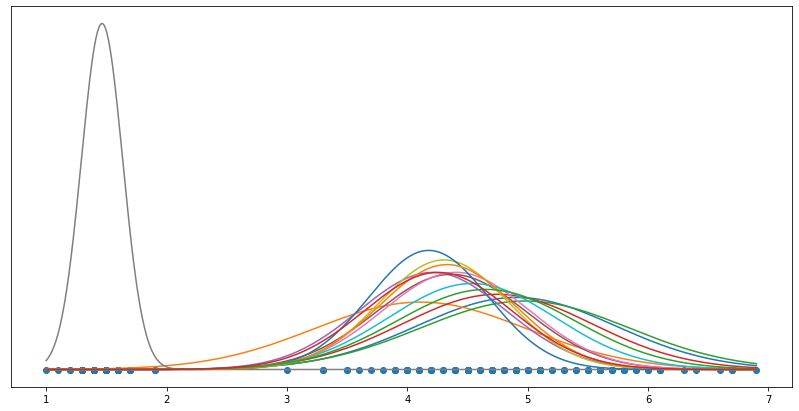

[1, 3, 8, 10, 13, 14] 0
[-1, 1, 3, 8, 10, 13, 14] 1
[-1, 1, 3, 8, 10, 13, 14] 2
[-1, 1, -1, 3, 8, 10, 13, 14] 3
[-1, 1, -1, 3, 8, 10, 13, 14] 4
[-1, 1, -1, 3, -1, 8, 10, 13, 14] 5
[-1, 1, -1, 3, -1, -1, 8, 10, 13, 14] 6
[-1, 1, -1, 3, -1, -1, -1, 8, 10, 13, 14] 7
[-1, 1, -1, 3, -1, -1, -1, -1, 8, 10, 13, 14] 8
[-1, 1, -1, 3, -1, -1, -1, -1, 8, 10, 13, 14] 9
[-1, 1, -1, 3, -1, -1, -1, -1, 8, -1, 10, 13, 14] 10
[-1, 1, -1, 3, -1, -1, -1, -1, 8, -1, 10, 13, 14] 11
[-1, 1, -1, 3, -1, -1, -1, -1, 8, -1, 10, -1, 13, 14] 12
[-1, 1, -1, 3, -1, -1, -1, -1, 8, -1, 10, -1, -1, 13, 14] 13
[-1, 1, -1, 3, -1, -1, -1, -1, 8, -1, 10, -1, -1, 13, 14] 14
[3, 10, 13] 0
[-1, 3, 10, 13] 1
[-1, -1, 3, 10, 13] 2
[-1, -1, -1, 3, 10, 13] 3
[-1, -1, -1, 3, 10, 13] 4
[-1, -1, -1, 3, -1, 10, 13] 5
[-1, -1, -1, 3, -1, -1, 10, 13] 6
[-1, -1, -1, 3, -1, -1, -1, 10, 13] 7
[-1, -1, -1, 3, -1, -1, -1, -1, 10, 13] 8
[-1, -1, -1, 3, -1, -1, -1, -1, -1, 10, 13] 9
[-1, -1, -1, 3, -1, -1, -1, -1, -1, -1, 10, 13] 10
[-1, -1,

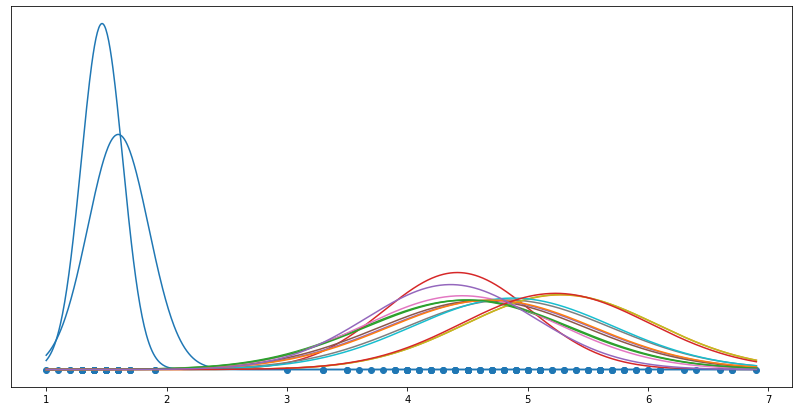

best model:


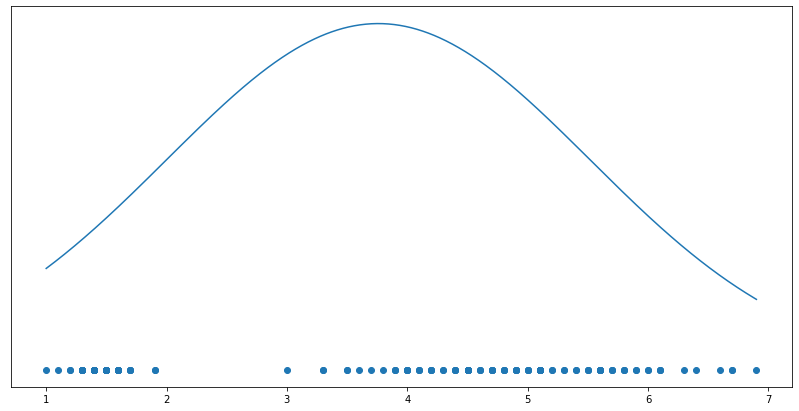

In [14]:
sel_plt(iris_x)

[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
[0] 0
1 2790.4060160663075


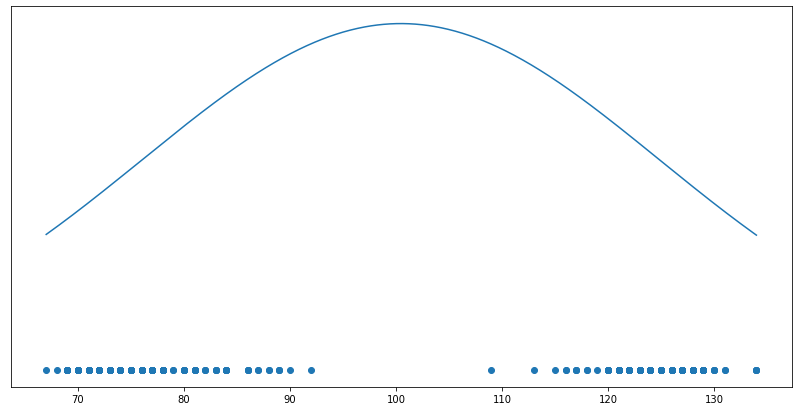

This is the new best model according to aic!
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
[0, 1] 0
[0, 1] 1
2 2203.9131940815037


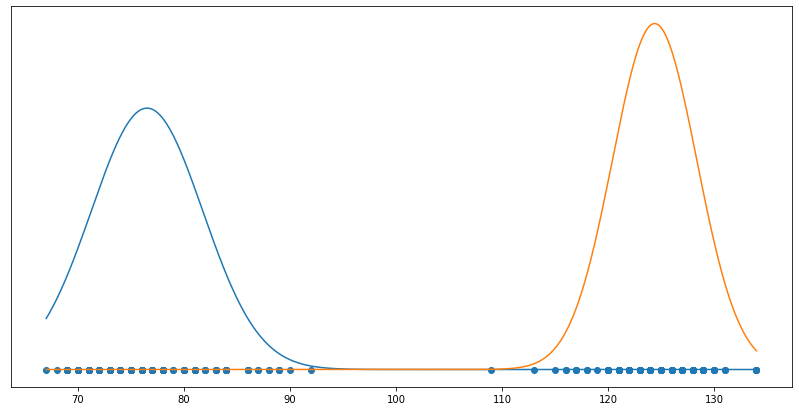

[0, 1, 2] 0
[0, 1, 2] 1
[0, 1, 2] 2
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1] 0
[0, 1] 1
[0, 1] 2
[0, 1, 2] 0
[0, 1, 2] 1
[0, 1, 2] 2
[0] 0
[0] 1
[0, -1] 2
[0] 0
[0] 1
[0, -1] 2
[0] 0
[0] 1
[0, -1] 2
3 nan


<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))
<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: divide by zero encountered in true_divide
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))
<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: invalid value encountered in true_divide
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))
<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: invalid value encountered in multiply
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))


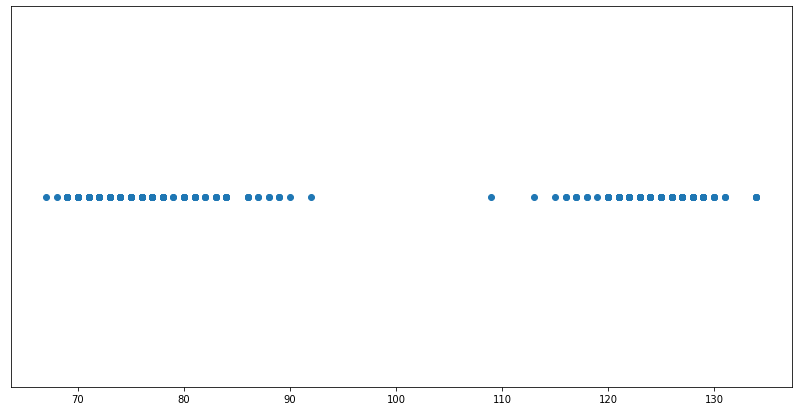

[0, 1, 2, 3] 0
[0, 1, 2, 3] 1
[0, 1, 2, 3] 2
[0, 1, 2, 3] 3
[0, 1, 2] 0
[0, 1, 2] 1
[0, 1, 2] 2
[0, 1, 2] 3
[0, 1, 2] 0
[0, 1, 2] 1
[0, 1, 2] 2
[0, 1, 2] 3
[0, 1, 2] 0
[0, 1, 2] 1
[0, 1, 2] 2
[0, 1, 2] 3
[0, 1, 2] 0
[0, 1, 2] 1
[0, 1, 2] 2
[0, 1, 2] 3
[0, 1, 2] 0
[0, 1, 2] 1
[0, 1, 2] 2
[0, 1, 2] 3
[0, 1, 2] 0
[0, 1, 2] 1
[0, 1, 2] 2
[0, 1, 2] 3
[0, 1, 2] 0
[0, 1, 2] 1
[0, 1, 2] 2
[0, 1, 2] 3
[0, 1, 2] 0
[0, 1, 2] 1
[0, 1, 2] 2
[0, 1, 2] 3
[0, 1, 2] 0
[0, 1, 2] 1
[0, 1, 2] 2
[0, 1, 2] 3
4 2210.2637283221384


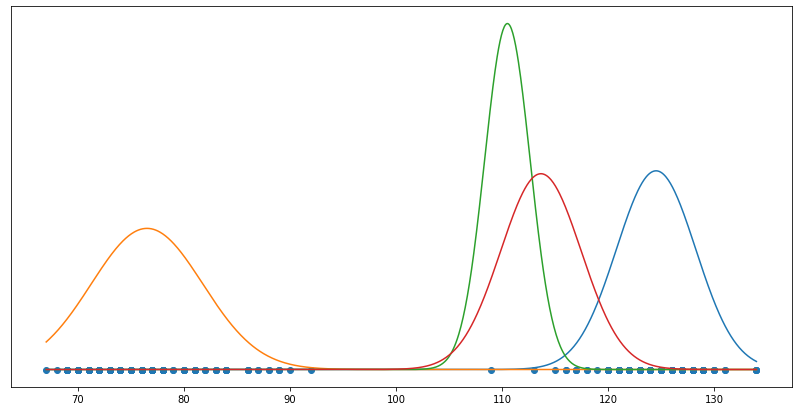

[0, 1, 2, 3, 4] 0
[0, 1, 2, 3, 4] 1
[0, 1, 2, 3, 4] 2
[0, 1, 2, 3, 4] 3
[0, 1, 2, 3, 4] 4
[2, 3, 4] 0
[-1, 2, 3, 4] 1
[-1, -1, 2, 3, 4] 2
[-1, -1, 2, 3, 4] 3
[-1, -1, 2, 3, 4] 4
[2, 3, 4] 0
[-1, 2, 3, 4] 1
[-1, -1, 2, 3, 4] 2
[-1, -1, 2, 3, 4] 3
[-1, -1, 2, 3, 4] 4
[2, 3, 4] 0
[-1, 2, 3, 4] 1
[-1, -1, 2, 3, 4] 2
[-1, -1, 2, 3, 4] 3
[-1, -1, 2, 3, 4] 4
[2, 3, 4] 0
[-1, 2, 3, 4] 1
[-1, -1, 2, 3, 4] 2
[-1, -1, 2, 3, 4] 3
[-1, -1, 2, 3, 4] 4
[2, 3, 4] 0
[-1, 2, 3, 4] 1
[-1, -1, 2, 3, 4] 2
[-1, -1, 2, 3, 4] 3
[-1, -1, 2, 3, 4] 4
[2, 3, 4] 0
[-1, 2, 3, 4] 1
[-1, -1, 2, 3, 4] 2
[-1, -1, 2, 3, 4] 3
[-1, -1, 2, 3, 4] 4
[2, 3, 4] 0
[-1, 2, 3, 4] 1
[-1, -1, 2, 3, 4] 2
[-1, -1, 2, 3, 4] 3
[-1, -1, 2, 3, 4] 4
[2, 3, 4] 0
[-1, 2, 3, 4] 1
[-1, -1, 2, 3, 4] 2
[-1, -1, 2, 3, 4] 3
[-1, -1, 2, 3, 4] 4
[2, 3, 4] 0
[-1, 2, 3, 4] 1
[-1, -1, 2, 3, 4] 2
[-1, -1, 2, 3, 4] 3
[-1, -1, 2, 3, 4] 4
5 2201.7928964858565


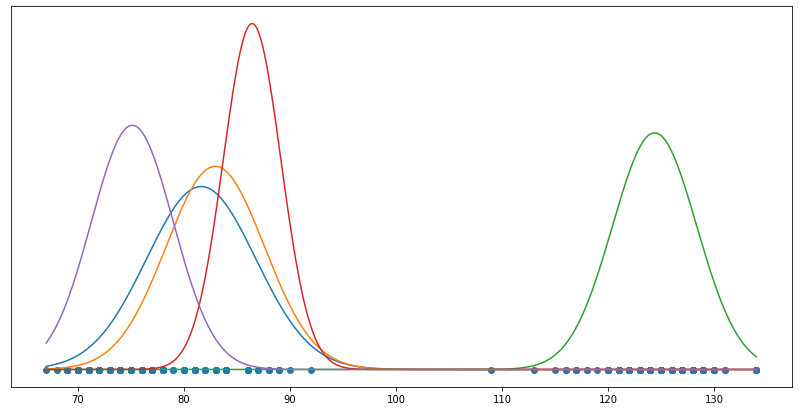

[0, 2, 3, 4, 5] 0
[0, 2, 3, 4, 5] 1
[0, -1, 2, 3, 4, 5] 2
[0, -1, 2, 3, 4, 5] 3
[0, -1, 2, 3, 4, 5] 4
[0, -1, 2, 3, 4, 5] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
[0, 2, 4] 0
[0, 2, 4] 1
[0, -1, 2, 4] 2
[0, -1, 2, 4] 3
[0, -1, 2, -1, 4] 4
[0, -1, 2, -1, 4] 5
6 2222.32279

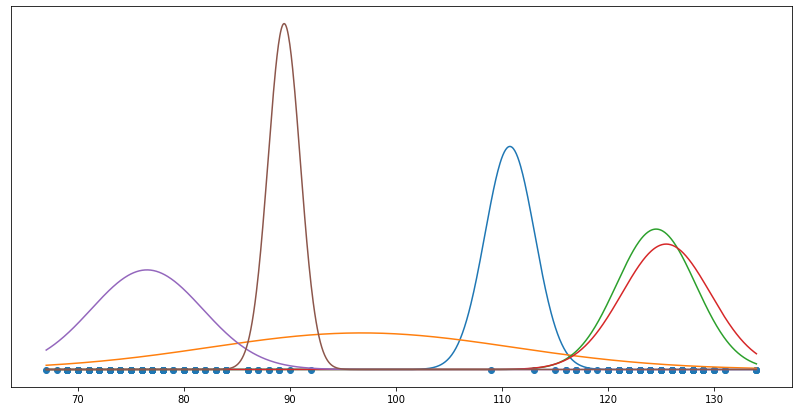

[0, 1, 2, 3, 4, 5, 6] 0
[0, 1, 2, 3, 4, 5, 6] 1
[0, 1, 2, 3, 4, 5, 6] 2
[0, 1, 2, 3, 4, 5, 6] 3
[0, 1, 2, 3, 4, 5, 6] 4
[0, 1, 2, 3, 4, 5, 6] 5
[0, 1, 2, 3, 4, 5, 6] 6
[0, 1, 2, 4, 5] 0
[0, 1, 2, 4, 5] 1
[0, 1, 2, 4, 5] 2
[0, 1, 2, 4, 5] 3
[0, 1, 2, -1, 4, 5] 4
[0, 1, 2, -1, 4, 5] 5
[0, 1, 2, -1, 4, 5] 6
[0, 1, 2, 4, 5] 0
[0, 1, 2, 4, 5] 1
[0, 1, 2, 4, 5] 2
[0, 1, 2, 4, 5] 3
[0, 1, 2, -1, 4, 5] 4
[0, 1, 2, -1, 4, 5] 5
[0, 1, 2, -1, 4, 5] 6
[0, 1, 4, 5] 0
[0, 1, 4, 5] 1
[0, 1, 4, 5] 2
[0, 1, -1, 4, 5] 3
[0, 1, -1, -1, 4, 5] 4
[0, 1, -1, -1, 4, 5] 5
[0, 1, -1, -1, 4, 5] 6
[0, 1, 4, 5] 0
[0, 1, 4, 5] 1
[0, 1, 4, 5] 2
[0, 1, -1, 4, 5] 3
[0, 1, -1, -1, 4, 5] 4
[0, 1, -1, -1, 4, 5] 5
[0, 1, -1, -1, 4, 5] 6
[0, 1, 4, 5] 0
[0, 1, 4, 5] 1
[0, 1, 4, 5] 2
[0, 1, -1, 4, 5] 3
[0, 1, -1, -1, 4, 5] 4
[0, 1, -1, -1, 4, 5] 5
[0, 1, -1, -1, 4, 5] 6
[0, 1, 4, 5] 0
[0, 1, 4, 5] 1
[0, 1, 4, 5] 2
[0, 1, -1, 4, 5] 3
[0, 1, -1, -1, 4, 5] 4
[0, 1, -1, -1, 4, 5] 5
[0, 1, -1, -1, 4, 5] 6
[0, 1, 4, 5] 0
[0, 1, 4,

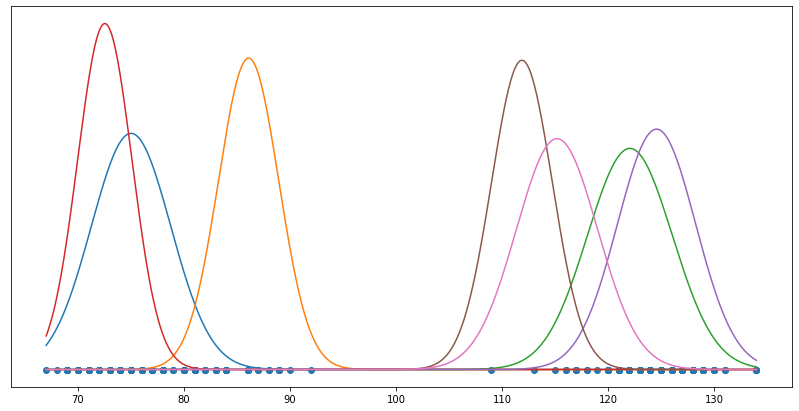

[0, 1, 2, 4, 5, 6, 7] 0
[0, 1, 2, 4, 5, 6, 7] 1
[0, 1, 2, 4, 5, 6, 7] 2
[0, 1, 2, 4, 5, 6, 7] 3
[0, 1, 2, -1, 4, 5, 6, 7] 4
[0, 1, 2, -1, 4, 5, 6, 7] 5
[0, 1, 2, -1, 4, 5, 6, 7] 6
[0, 1, 2, -1, 4, 5, 6, 7] 7
[0, 1, 2, 4, 5, 7] 0
[0, 1, 2, 4, 5, 7] 1
[0, 1, 2, 4, 5, 7] 2
[0, 1, 2, 4, 5, 7] 3
[0, 1, 2, -1, 4, 5, 7] 4
[0, 1, 2, -1, 4, 5, 7] 5
[0, 1, 2, -1, 4, 5, 7] 6
[0, 1, 2, -1, 4, 5, -1, 7] 7
[1, 2, 4, 5, 7] 0
[-1, 1, 2, 4, 5, 7] 1
[-1, 1, 2, 4, 5, 7] 2
[-1, 1, 2, 4, 5, 7] 3
[-1, 1, 2, -1, 4, 5, 7] 4
[-1, 1, 2, -1, 4, 5, 7] 5
[-1, 1, 2, -1, 4, 5, 7] 6
[-1, 1, 2, -1, 4, 5, -1, 7] 7
[1, 2, 5, 7] 0
[-1, 1, 2, 5, 7] 1
[-1, 1, 2, 5, 7] 2
[-1, 1, 2, 5, 7] 3
[-1, 1, 2, -1, 5, 7] 4
[-1, 1, 2, -1, -1, 5, 7] 5
[-1, 1, 2, -1, -1, 5, 7] 6
[-1, 1, 2, -1, -1, 5, -1, 7] 7
[1, 2, 5, 7] 0
[-1, 1, 2, 5, 7] 1
[-1, 1, 2, 5, 7] 2
[-1, 1, 2, 5, 7] 3
[-1, 1, 2, -1, 5, 7] 4
[-1, 1, 2, -1, -1, 5, 7] 5
[-1, 1, 2, -1, -1, 5, 7] 6
[-1, 1, 2, -1, -1, 5, -1, 7] 7
[1, 2, 5, 7] 0
[-1, 1, 2, 5, 7] 1
[-1, 1, 2, 5, 7] 2

<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))
<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: divide by zero encountered in true_divide
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))
<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: invalid value encountered in true_divide
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))
<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: invalid value encountered in multiply
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))
<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))
<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: divide by zero encountered in true_divide
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((

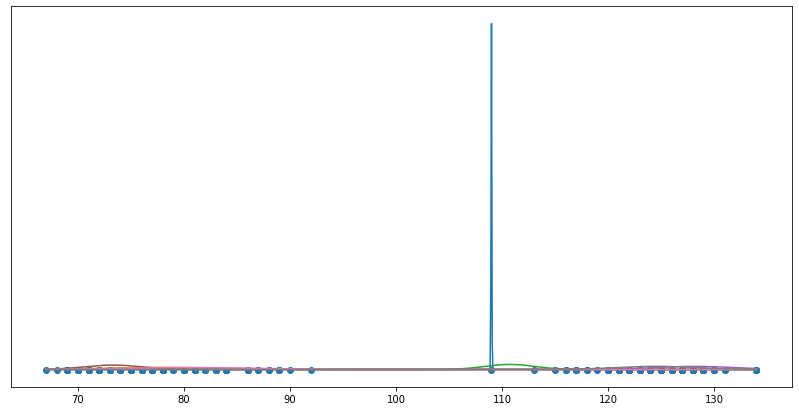

[0, 2, 4, 5, 6, 7, 8] 0
[0, 2, 4, 5, 6, 7, 8] 1
[0, -1, 2, 4, 5, 6, 7, 8] 2
[0, -1, 2, 4, 5, 6, 7, 8] 3
[0, -1, 2, -1, 4, 5, 6, 7, 8] 4
[0, -1, 2, -1, 4, 5, 6, 7, 8] 5
[0, -1, 2, -1, 4, 5, 6, 7, 8] 6
[0, -1, 2, -1, 4, 5, 6, 7, 8] 7
[0, -1, 2, -1, 4, 5, 6, 7, 8] 8
[0, 2, 4, 6, 7, 8] 0
[0, 2, 4, 6, 7, 8] 1
[0, -1, 2, 4, 6, 7, 8] 2
[0, -1, 2, 4, 6, 7, 8] 3
[0, -1, 2, -1, 4, 6, 7, 8] 4
[0, -1, 2, -1, 4, 6, 7, 8] 5
[0, -1, 2, -1, 4, -1, 6, 7, 8] 6
[0, -1, 2, -1, 4, -1, 6, 7, 8] 7
[0, -1, 2, -1, 4, -1, 6, 7, 8] 8
[0, 2, 6, 7, 8] 0
[0, 2, 6, 7, 8] 1
[0, -1, 2, 6, 7, 8] 2
[0, -1, 2, 6, 7, 8] 3
[0, -1, 2, -1, 6, 7, 8] 4
[0, -1, 2, -1, -1, 6, 7, 8] 5
[0, -1, 2, -1, -1, -1, 6, 7, 8] 6
[0, -1, 2, -1, -1, -1, 6, 7, 8] 7
[0, -1, 2, -1, -1, -1, 6, 7, 8] 8
[2, 6, 7, 8] 0
[-1, 2, 6, 7, 8] 1
[-1, -1, 2, 6, 7, 8] 2
[-1, -1, 2, 6, 7, 8] 3
[-1, -1, 2, -1, 6, 7, 8] 4
[-1, -1, 2, -1, -1, 6, 7, 8] 5
[-1, -1, 2, -1, -1, -1, 6, 7, 8] 6
[-1, -1, 2, -1, -1, -1, 6, 7, 8] 7
[-1, -1, 2, -1, -1, -1, 6, 7, 8] 8
[2, 6,

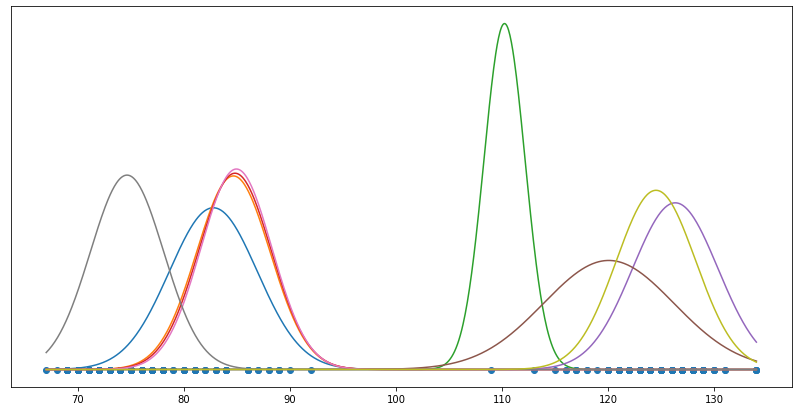

[2, 3, 4, 5, 6, 7, 8, 9] 0
[-1, 2, 3, 4, 5, 6, 7, 8, 9] 1
[-1, -1, 2, 3, 4, 5, 6, 7, 8, 9] 2
[-1, -1, 2, 3, 4, 5, 6, 7, 8, 9] 3
[-1, -1, 2, 3, 4, 5, 6, 7, 8, 9] 4
[-1, -1, 2, 3, 4, 5, 6, 7, 8, 9] 5
[-1, -1, 2, 3, 4, 5, 6, 7, 8, 9] 6
[-1, -1, 2, 3, 4, 5, 6, 7, 8, 9] 7
[-1, -1, 2, 3, 4, 5, 6, 7, 8, 9] 8
[-1, -1, 2, 3, 4, 5, 6, 7, 8, 9] 9
[2, 3, 4, 7, 9] 0
[-1, 2, 3, 4, 7, 9] 1
[-1, -1, 2, 3, 4, 7, 9] 2
[-1, -1, 2, 3, 4, 7, 9] 3
[-1, -1, 2, 3, 4, 7, 9] 4
[-1, -1, 2, 3, 4, 7, 9] 5
[-1, -1, 2, 3, 4, -1, 7, 9] 6
[-1, -1, 2, 3, 4, -1, -1, 7, 9] 7
[-1, -1, 2, 3, 4, -1, -1, 7, 9] 8
[-1, -1, 2, 3, 4, -1, -1, 7, -1, 9] 9
[2, 3, 4, 9] 0
[-1, 2, 3, 4, 9] 1
[-1, -1, 2, 3, 4, 9] 2
[-1, -1, 2, 3, 4, 9] 3
[-1, -1, 2, 3, 4, 9] 4
[-1, -1, 2, 3, 4, 9] 5
[-1, -1, 2, 3, 4, -1, 9] 6
[-1, -1, 2, 3, 4, -1, -1, 9] 7
[-1, -1, 2, 3, 4, -1, -1, -1, 9] 8
[-1, -1, 2, 3, 4, -1, -1, -1, -1, 9] 9
[2, 3, 4, 9] 0
[-1, 2, 3, 4, 9] 1
[-1, -1, 2, 3, 4, 9] 2
[-1, -1, 2, 3, 4, 9] 3
[-1, -1, 2, 3, 4, 9] 4
[-1, -1, 2, 3, 4, 9] 

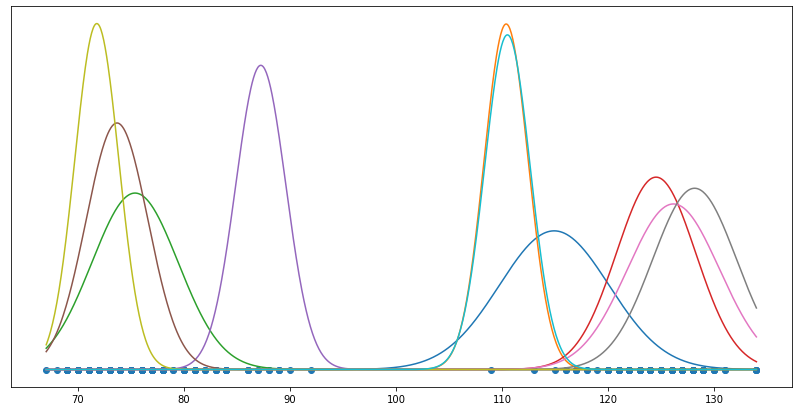

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10] 0
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10] 1
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10] 2
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10] 3
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10] 4
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10] 5
[0, 1, 2, 3, 4, -1, 6, 7, 8, 9, 10] 6
[0, 1, 2, 3, 4, -1, 6, 7, 8, 9, 10] 7
[0, 1, 2, 3, 4, -1, 6, 7, 8, 9, 10] 8
[0, 1, 2, 3, 4, -1, 6, 7, 8, 9, 10] 9
[0, 1, 2, 3, 4, -1, 6, 7, 8, 9, 10] 10
[1, 2, 3, 4, 7, 8, 10] 0
[-1, 1, 2, 3, 4, 7, 8, 10] 1
[-1, 1, 2, 3, 4, 7, 8, 10] 2
[-1, 1, 2, 3, 4, 7, 8, 10] 3
[-1, 1, 2, 3, 4, 7, 8, 10] 4
[-1, 1, 2, 3, 4, 7, 8, 10] 5
[-1, 1, 2, 3, 4, -1, 7, 8, 10] 6
[-1, 1, 2, 3, 4, -1, -1, 7, 8, 10] 7
[-1, 1, 2, 3, 4, -1, -1, 7, 8, 10] 8
[-1, 1, 2, 3, 4, -1, -1, 7, 8, 10] 9
[-1, 1, 2, 3, 4, -1, -1, 7, 8, -1, 10] 10
[1, 2, 4, 8, 10] 0
[-1, 1, 2, 4, 8, 10] 1
[-1, 1, 2, 4, 8, 10] 2
[-1, 1, 2, 4, 8, 10] 3
[-1, 1, 2, -1, 4, 8, 10] 4
[-1, 1, 2, -1, 4, 8, 10] 5
[-1, 1, 2, -1, 4, -1, 8, 10] 6
[-1, 1, 2, -1, 4, -1, -1, 8, 10] 7
[-1, 1, 2, -1, 4, -1, -1, -1, 8, 10] 8
[-

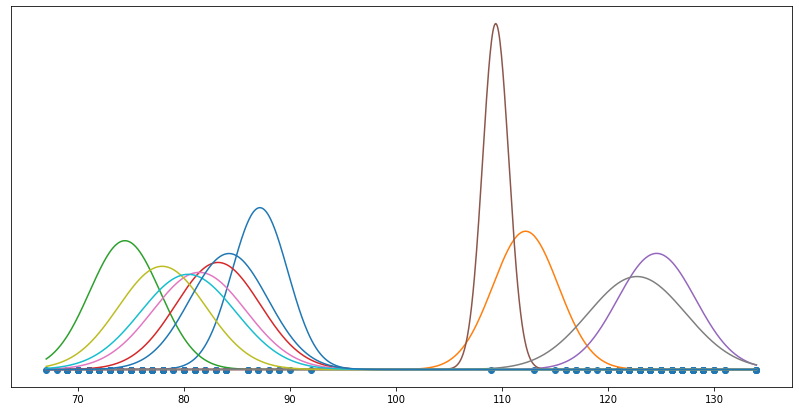

[2, 4, 5, 7, 9, 10, 11] 0
[-1, 2, 4, 5, 7, 9, 10, 11] 1
[-1, -1, 2, 4, 5, 7, 9, 10, 11] 2
[-1, -1, 2, 4, 5, 7, 9, 10, 11] 3
[-1, -1, 2, -1, 4, 5, 7, 9, 10, 11] 4
[-1, -1, 2, -1, 4, 5, 7, 9, 10, 11] 5
[-1, -1, 2, -1, 4, 5, 7, 9, 10, 11] 6
[-1, -1, 2, -1, 4, 5, -1, 7, 9, 10, 11] 7
[-1, -1, 2, -1, 4, 5, -1, 7, 9, 10, 11] 8
[-1, -1, 2, -1, 4, 5, -1, 7, -1, 9, 10, 11] 9
[-1, -1, 2, -1, 4, 5, -1, 7, -1, 9, 10, 11] 10
[-1, -1, 2, -1, 4, 5, -1, 7, -1, 9, 10, 11] 11
[2, 4, 7, 9, 10, 11] 0
[-1, 2, 4, 7, 9, 10, 11] 1
[-1, -1, 2, 4, 7, 9, 10, 11] 2
[-1, -1, 2, 4, 7, 9, 10, 11] 3
[-1, -1, 2, -1, 4, 7, 9, 10, 11] 4
[-1, -1, 2, -1, 4, 7, 9, 10, 11] 5
[-1, -1, 2, -1, 4, -1, 7, 9, 10, 11] 6
[-1, -1, 2, -1, 4, -1, -1, 7, 9, 10, 11] 7
[-1, -1, 2, -1, 4, -1, -1, 7, 9, 10, 11] 8
[-1, -1, 2, -1, 4, -1, -1, 7, -1, 9, 10, 11] 9
[-1, -1, 2, -1, 4, -1, -1, 7, -1, 9, 10, 11] 10
[-1, -1, 2, -1, 4, -1, -1, 7, -1, 9, 10, 11] 11
[2, 7, 9, 10, 11] 0
[-1, 2, 7, 9, 10, 11] 1
[-1, -1, 2, 7, 9, 10, 11] 2
[-1, -1, 2, 7, 9

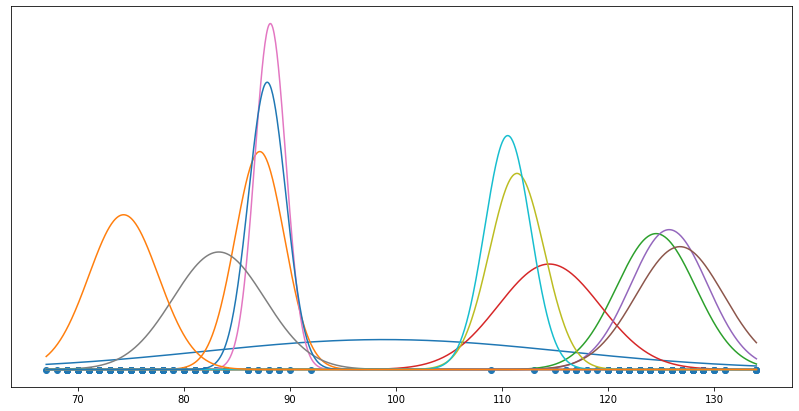

[0, 2, 3, 5, 7, 8, 9, 10, 12] 0
[0, 2, 3, 5, 7, 8, 9, 10, 12] 1
[0, -1, 2, 3, 5, 7, 8, 9, 10, 12] 2
[0, -1, 2, 3, 5, 7, 8, 9, 10, 12] 3
[0, -1, 2, 3, 5, 7, 8, 9, 10, 12] 4
[0, -1, 2, 3, -1, 5, 7, 8, 9, 10, 12] 5
[0, -1, 2, 3, -1, 5, 7, 8, 9, 10, 12] 6
[0, -1, 2, 3, -1, 5, -1, 7, 8, 9, 10, 12] 7
[0, -1, 2, 3, -1, 5, -1, 7, 8, 9, 10, 12] 8
[0, -1, 2, 3, -1, 5, -1, 7, 8, 9, 10, 12] 9
[0, -1, 2, 3, -1, 5, -1, 7, 8, 9, 10, 12] 10
[0, -1, 2, 3, -1, 5, -1, 7, 8, 9, 10, 12] 11
[0, -1, 2, 3, -1, 5, -1, 7, 8, 9, 10, -1, 12] 12
[0, 2, 5, 7, 9] 0
[0, 2, 5, 7, 9] 1
[0, -1, 2, 5, 7, 9] 2
[0, -1, 2, 5, 7, 9] 3
[0, -1, 2, -1, 5, 7, 9] 4
[0, -1, 2, -1, -1, 5, 7, 9] 5
[0, -1, 2, -1, -1, 5, 7, 9] 6
[0, -1, 2, -1, -1, 5, -1, 7, 9] 7
[0, -1, 2, -1, -1, 5, -1, 7, 9] 8
[0, -1, 2, -1, -1, 5, -1, 7, -1, 9] 9
[0, -1, 2, -1, -1, 5, -1, 7, -1, 9] 10
[0, -1, 2, -1, -1, 5, -1, 7, -1, 9, -1] 11
[0, -1, 2, -1, -1, 5, -1, 7, -1, 9, -1, -1] 12
[0, 2, 5, 7, 9] 0
[0, 2, 5, 7, 9] 1
[0, -1, 2, 5, 7, 9] 2
[0, -1, 2, 5, 7, 9

<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))
<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: divide by zero encountered in true_divide
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))
<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: invalid value encountered in true_divide
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))
<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: invalid value encountered in multiply
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))


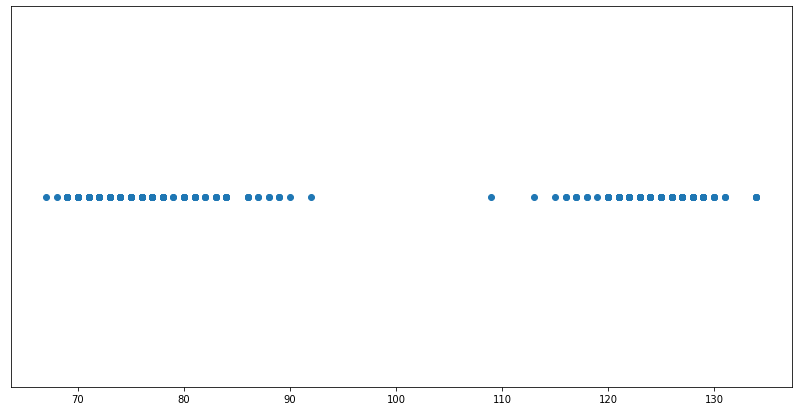

[0, 2, 3, 6, 8, 9, 10, 11, 12] 0
[0, 2, 3, 6, 8, 9, 10, 11, 12] 1
[0, -1, 2, 3, 6, 8, 9, 10, 11, 12] 2
[0, -1, 2, 3, 6, 8, 9, 10, 11, 12] 3
[0, -1, 2, 3, 6, 8, 9, 10, 11, 12] 4
[0, -1, 2, 3, -1, 6, 8, 9, 10, 11, 12] 5
[0, -1, 2, 3, -1, -1, 6, 8, 9, 10, 11, 12] 6
[0, -1, 2, 3, -1, -1, 6, 8, 9, 10, 11, 12] 7
[0, -1, 2, 3, -1, -1, 6, -1, 8, 9, 10, 11, 12] 8
[0, -1, 2, 3, -1, -1, 6, -1, 8, 9, 10, 11, 12] 9
[0, -1, 2, 3, -1, -1, 6, -1, 8, 9, 10, 11, 12] 10
[0, -1, 2, 3, -1, -1, 6, -1, 8, 9, 10, 11, 12] 11
[0, -1, 2, 3, -1, -1, 6, -1, 8, 9, 10, 11, 12] 12
[0, -1, 2, 3, -1, -1, 6, -1, 8, 9, 10, 11, 12] 13
[0, 2, 8, 9, 12] 0
[0, 2, 8, 9, 12] 1
[0, -1, 2, 8, 9, 12] 2
[0, -1, 2, 8, 9, 12] 3
[0, -1, 2, -1, 8, 9, 12] 4
[0, -1, 2, -1, -1, 8, 9, 12] 5
[0, -1, 2, -1, -1, -1, 8, 9, 12] 6
[0, -1, 2, -1, -1, -1, -1, 8, 9, 12] 7
[0, -1, 2, -1, -1, -1, -1, -1, 8, 9, 12] 8
[0, -1, 2, -1, -1, -1, -1, -1, 8, 9, 12] 9
[0, -1, 2, -1, -1, -1, -1, -1, 8, 9, 12] 10
[0, -1, 2, -1, -1, -1, -1, -1, 8, 9, -1, 12] 11


<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))
<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: divide by zero encountered in true_divide
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))
<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: invalid value encountered in true_divide
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))
<ipython-input-3-5c1c79632d0b>:9: RuntimeWarning: invalid value encountered in multiply
  return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))


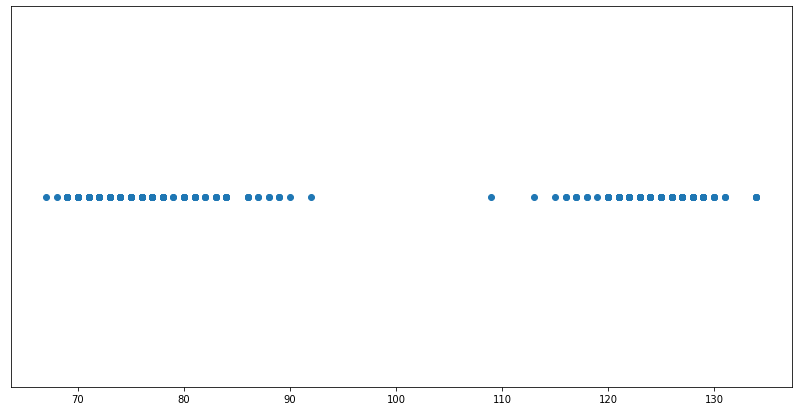

[1, 2, 3, 5, 7, 8, 10, 11, 13, 14] 0
[-1, 1, 2, 3, 5, 7, 8, 10, 11, 13, 14] 1
[-1, 1, 2, 3, 5, 7, 8, 10, 11, 13, 14] 2
[-1, 1, 2, 3, 5, 7, 8, 10, 11, 13, 14] 3
[-1, 1, 2, 3, 5, 7, 8, 10, 11, 13, 14] 4
[-1, 1, 2, 3, -1, 5, 7, 8, 10, 11, 13, 14] 5
[-1, 1, 2, 3, -1, 5, 7, 8, 10, 11, 13, 14] 6
[-1, 1, 2, 3, -1, 5, -1, 7, 8, 10, 11, 13, 14] 7
[-1, 1, 2, 3, -1, 5, -1, 7, 8, 10, 11, 13, 14] 8
[-1, 1, 2, 3, -1, 5, -1, 7, 8, 10, 11, 13, 14] 9
[-1, 1, 2, 3, -1, 5, -1, 7, 8, -1, 10, 11, 13, 14] 10
[-1, 1, 2, 3, -1, 5, -1, 7, 8, -1, 10, 11, 13, 14] 11
[-1, 1, 2, 3, -1, 5, -1, 7, 8, -1, 10, 11, 13, 14] 12
[-1, 1, 2, 3, -1, 5, -1, 7, 8, -1, 10, 11, -1, 13, 14] 13
[-1, 1, 2, 3, -1, 5, -1, 7, 8, -1, 10, 11, -1, 13, 14] 14
[1, 2, 5, 7, 8] 0
[-1, 1, 2, 5, 7, 8] 1
[-1, 1, 2, 5, 7, 8] 2
[-1, 1, 2, 5, 7, 8] 3
[-1, 1, 2, -1, 5, 7, 8] 4
[-1, 1, 2, -1, -1, 5, 7, 8] 5
[-1, 1, 2, -1, -1, 5, 7, 8] 6
[-1, 1, 2, -1, -1, 5, -1, 7, 8] 7
[-1, 1, 2, -1, -1, 5, -1, 7, 8] 8
[-1, 1, 2, -1, -1, 5, -1, 7, 8] 9
[-1, 1, 2, -

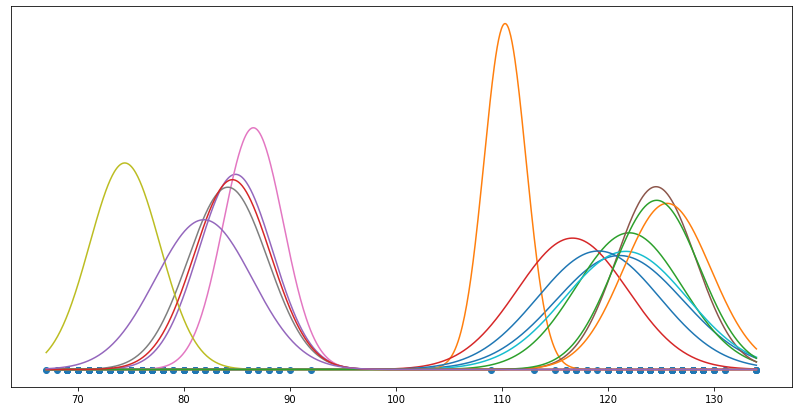

best model:


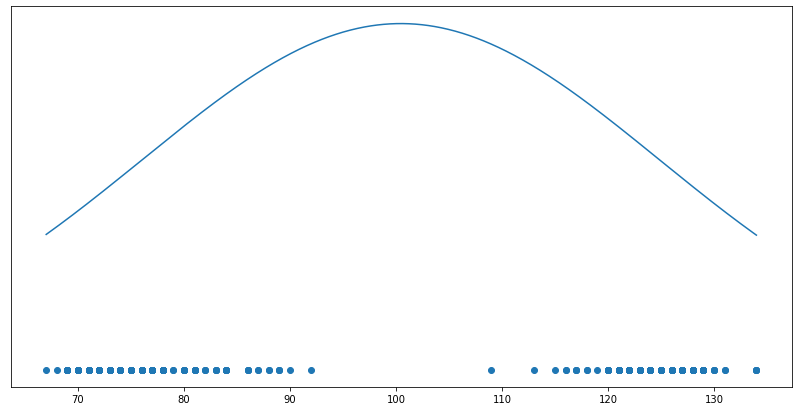

In [15]:
sel_plt(bdp_x)